<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch
## Main_RandomTic_Filter_AVDataset_Dow30_Daily
Network with 128 neutrons and 2 layers

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Check Additional Packages](#1.1)
    * [2.2. Import Packages](#1.2)
    * [2.3. Create Folders & Relevant Configurations¶](#1.3)
* [3. Download Data](#2)
* [4. Preprocess fundamental data](#3)        
    * [4.1. Import the financial data](#3.1)
    * [4.2. Specify items needed to calculate financial ratios](#3.2)
    * [4.3. Turn the final_ratios to daily basis](#3.3)
    * [4.4. Merge stock price data and ratios into one dataframe](#3.4)
    * [4.5. Finish data preparation](#3.5)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. Set up the training environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Train DRL Agent](#5)  
* [7.Backtest Our Strategy](#6)  
    * [7.1. BackTest with DJIA](#6.1)
    * [7.2. BackTest with Buy&Hold Strategy](#6.2)
* [8.Save & load model](#7)
    * [8.1. Save model](#7.1)
    * [8.2. Load model](#7.2)

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Alpha Vantage API. The data contains Open-High-Low-Close price and volume.


### If continuing the previous training, jump to [**this point**](#8.1)

<a id='1'></a>
# Part 2. Getting Started- Load Python Packages


<a id='1.1'></a>
## 2.1. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.2'></a>
## 2.2. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import math
from stable_baselines3.common.logger import configure

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.3'></a>
## 2.3. Create Folders & Relevant Configurations

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [4]:
from datetime import datetime
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

# Load price data from csv file
tic_dir = './' + DATA_SAVE_DIR + '/sp500_price_daily.csv'
df = pd.read_csv(tic_dir,index_col=0)

If the data is available locally, we can skip downloading steps and jump directly to part [**4.5.Finish data preparation**](#3.5)

<a id='2'></a>
# Part 3. Download Price Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# Download data from YFinance
# tic_dir = './' + DATA_SAVE_DIR + '/sp500_ticker.csv'
# tic_list = pd.read_csv(tic_dir,index_col=0)
# SP_500_TICKER = np.array(tic_list.tic).tolist()
# df = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = SP_500_TICKER).fetch_data()

In [6]:
# df.head()

In [7]:
# df.tail()

In [8]:
# df.shape

In [9]:
# df.sort_values(['date','tic']).head()

In [10]:
# len(df.tic.unique())

In [11]:
# df.tic.value_counts()

<a id='3'></a>
# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Alpha Vantage
- Preprocess the dataset and calculate financial ratios
- Turn yearly ratio into daily basis

<a id='3.1'></a>
## 4.1 Import the financial data

#### Define configurations of the collecting data & download data via Alpha Vantage API

In [12]:
# import requests

# api_key = 'GZWRUSYXT18ZTR6C'
# features_cols = ['fiscalDateEnding','totalRevenue','costOfRevenue','sellingGeneralAndAdministrative','researchAndDevelopment','depreciation','interestExpense','totalCurrentLiabilities','incomeTaxExpense','netIncome','commonStockSharesOutstanding','cashAndCashEquivalentsAtCarryingValue','cashAndShortTermInvestments','operatingCashflow','totalLiabilities','inventory','currentNetReceivables','propertyPlantEquipment','capitalExpenditures','longTermInvestments','totalShareholderEquity','longTermDebt','retainedEarnings','dividendPayoutCommonStock','paymentsForRepurchaseOfCommonStock','treasuryStock','currentLongTermDebt']
# price_cols = ['open','high','low','close','volume']

Function to download fundamental data from financial reports by ticket

In [13]:
# def collect_fundamental(ticket):
#     # Download income statement
#     url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_is = r.json()

#     # Download balance sheet
#     url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_bs = r.json()

#     # Download cash flow
#     url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_cf = r.json()

#     df_is = pd.json_normalize(data_is['annualReports'])
#     df_bs = pd.json_normalize(data_bs['annualReports'])
#     df_cf = pd.json_normalize(data_cf['annualReports'])

#     merged_df = df_is.merge(df_bs).merge(df_cf)
#     merged_df['tic'] = ticket
#     merged_df = merged_df[['tic']+features_cols]
#     merged_df['fiscalDateEnding'] = pd.to_datetime(merged_df.fiscalDateEnding,format='mixed')

#     return merged_df

Function to download stock price by ticket

In [14]:
# def collect_price(ticket):
#     url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_monthly_price = r.json()

#     price_monthly = pd.DataFrame.from_dict(data_monthly_price['Monthly Time Series'], orient='index')
#     price_monthly.columns = price_cols
#     price_monthly['fiscalDateEnding'] = pd.to_datetime(price_monthly.index,format='mixed')
#     price_monthly.reset_index(inplace=True,drop=True)
#     price_monthly = price_monthly[['fiscalDateEnding','open','high','low','close','volume']]
#     return price_monthly

Function to merge monthly stock price into yearly fundamental data

In [15]:
# def merge_price_to_df(merged_df,price_monthly):
#     merged_df['year'] = merged_df.fiscalDateEnding.dt.year
#     merged_df['month'] = merged_df.fiscalDateEnding.dt.month
#     price_monthly['year'] = price_monthly.fiscalDateEnding.dt.year
#     price_monthly['month'] = price_monthly.fiscalDateEnding.dt.month
#     merged_final = pd.merge(merged_df,price_monthly,how="left",on=['year','month'])
#     merged_final.drop(columns=['year','month','fiscalDateEnding_y'],inplace=True)
#     merged_final = df_final.rename(columns={'fiscalDateEnding_x': 'date'})
#     merged_final['tic'] = ticket

#     merged_columns = [merged_final.columns[-1]]
#     for i in range(0,len(merged_final.columns)-1):
#         merged_columns.append(merged_final.columns[i])
#     merged_final = merged_final[merged_columns]
    
#     return merged_final

In [16]:
# download_tics = SP_500_TICKER[453:]
# print(download_tics)

In [17]:
# fund_data = pd.DataFrame()

# for ticket in download_tics:
#     df_fund = collect_fundamental(ticket)
#     fund_data = pd.concat([fund_data, df_fund], ignore_index=True)

In [18]:
# fund_data.to_csv('sp500_6.csv')

In [19]:
# Check dropped tickers which are not available data to download from Alpha Vantage

# tics_1 = pd.DataFrame()
# tics_2 = pd.DataFrame()
# tics_1['tic'] = df.tic.unique()
# tics_2['tic'] = fund_data.tic.unique()

# merged_df = tics_1.merge(tics_2, how='outer', indicator=True)
# unique_in_df = merged_df[merged_df['_merge'] == 'left_only']
# unique_in_df

#### Check reach download limitation

In [20]:
# url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=IBM&apikey=GZWRUSYXT18ZTR6C'
# r = requests.get(url)
# data_is = r.json()
# data_is

#### Load data from csv file

In [38]:
fund_data = pd.read_csv('./' + DATA_SAVE_DIR + '/dow30_fundamental.csv',index_col=0)
# fund_data = fund_data.rename(columns={'fiscalDateEnding_x':'date'})
fund_data['date'] = pd.to_datetime(fund_data.date,format='mixed')
fund_data

tic       date  totalRevenue  costOfRevenue  \
0    WBA 2023-08-31  140471000000   149818000000   
1    WBA 2022-08-31  132961000000   134560000000   
2    WBA 2021-08-31  131917000000   130222000000   
3    WBA 2020-08-31  138974000000   141859000000   
4    WBA 2019-08-31  136162000000   132887000000   
..   ...        ...           ...            ...   
416  TRV 2013-12-31   26191000000    31347000000   
417  TRV 2012-12-31   25740000000    33077000000   
418  TRV 2011-12-31   25446000000    36202000000   
419  TRV 2010-12-31   25112000000    29826000000   
420  TRV 2009-12-31   24680000000    28182000000   

     sellingGeneralAndAdministrative  researchAndDevelopment  depreciation  \
0                       3.420500e+10             371000000.0  0.000000e+00   
1                       2.729500e+10             307000000.0  0.000000e+00   
2                       2.458600e+10             284000000.0  0.000000e+00   
3                       2.543600e+10             300000000.0  0.000000e+00   
4                       2.355700e+10             260000000.0  1.500000e+09   
..                               ...                     ...           ...   
416                     3.757000e+09                     0.0  0.000000e+00   
417                     3.610000e+09                     0.0  0.000000e+00   
418                     3.556000e+09                     0.0  0.000000e+00   
419                     3.406000e+09                     0.0  0.000000e+00   
420                     3.366000e+09                     0.0  0.000000e+00   

     interestExpense  totalCurrentLiabilities  incomeTaxExpense  ...  \
0        580000000.0             2.453500e+10       -1858000000  ...   
1        400000000.0             2.258300e+10         -30000000  ...   
2        905000000.0             2.205400e+10         667000000  ...   
3        613000000.0             2.707000e+10         339000000  ...   
4        650000000.0             2.576900e+10         577000000  ...   
..               ...                      ...               ...  ...   
416      361000000.0             3.160000e+08        1272000000  ...   
417      378000000.0             1.199000e+09         693000000  ...   
418      386000000.0             5.240000e+08         -74000000  ...   
419      388000000.0             3.740000e+08        1090000000  ...   
420      382000000.0             5.230000e+08        1089000000  ...   

     propertyPlantEquipment  capitalExpenditures  longTermInvestments  \
0              1.090900e+10         2.117000e+09         3.497000e+09   
1              2.388400e+10         1.734000e+09         5.495000e+09   
2              1.224700e+10         1.379000e+09         6.987000e+09   
3              1.279600e+10         1.374000e+09         7.338000e+09   
4              1.347800e+10         1.702000e+09         6.851000e+09   
..                      ...                  ...                  ...   
416            0.000000e+00         8.900000e+07         7.316000e+10   
417            0.000000e+00         9.500000e+07         7.459000e+10   
418            0.000000e+00         6.500000e+07         7.346900e+10   
419            0.000000e+00         0.000000e+00         7.351300e+10   
420            0.000000e+00         0.000000e+00         7.579000e+10   

     totalShareholderEquity  longTermDebt  retainedEarnings  \
0               20020000000  9.092000e+09      3.305800e+10   
1               25275000000  1.170800e+10      3.780100e+10   
2               23419000000  9.018000e+09      3.512100e+10   
3               20637000000  1.581600e+10      3.421000e+10   
4               23512000000  1.691600e+10      3.581500e+10   
..                      ...           ...               ...   
416             24796000000  6.261000e+09      2.429100e+10   
417             25405000000  1.447200e+10      2.135200e+10   
418             24477000000  8.060000e+09      1.957900e+10   
419             25475000000  7.319000e+09      1.884700e+10   
420     

Select tickers in DJ index only.

In [39]:
fund_data = fund_data[fund_data.tic.isin(DOW_30_TICKER)].reset_index(drop=True)
fund_data.tic.nunique()

30

In [40]:
# UTIL TOOL: merge yearly fundamental data to daily stock price

start_date = df.iloc[0].date
end_date = df.iloc[-1].date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_range = pd.DataFrame(date_range)
date_range.columns = ['date']

fund_data = fund_data.rename(columns={'fiscalDateEnding':'date'})
fund_data['date'] = pd.to_datetime(fund_data.date,format='mixed')

fund_data_with_price = pd.DataFrame()
for ticket in fund_data.tic.unique():
    price_by_ticket = df[df.tic == ticket]
    price_by_ticket['date'] = pd.to_datetime(price_by_ticket['date'],format='mixed')
    price_by_ticket = pd.merge(date_range,price_by_ticket,how='left')
    price_by_ticket.bfill(inplace=True)
    price_by_ticket = pd.merge(fund_data.loc[fund_data.tic==ticket],price_by_ticket,how='left',on=['date'])
    price_by_ticket.drop(columns=['tic_y','day'],inplace=True,axis=0)
    price_by_ticket = price_by_ticket.rename(columns={'tic_x':'tic'})
    fund_data_with_price = pd.concat([fund_data_with_price, price_by_ticket], ignore_index=True)

fund_data = fund_data_with_price

#### Data cleaning ####
Refine the data before computing fundamental ratios

In [41]:
print(fund_data.info(),'\n')
print(fund_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   tic                                    421 non-null    object        
 1   date                                   421 non-null    datetime64[ns]
 2   totalRevenue                           421 non-null    int64         
 3   costOfRevenue                          421 non-null    int64         
 4   sellingGeneralAndAdministrative        421 non-null    float64       
 5   researchAndDevelopment                 421 non-null    float64       
 6   depreciation                           421 non-null    float64       
 7   interestExpense                        421 non-null    float64       
 8   totalCurrentLiabilities                421 non-null    float64       
 9   incomeTaxExpense                       421 non-null    int64     

The company with zero totalRevenue might cause problems for computing ratios while it is the denominator in some formulars.<br>
Deleting all tickers containing this issue is a good solution.

In [42]:
zero_revenue_tics = fund_data[fund_data.totalRevenue == 0].tic.unique()
fund_data = fund_data[~fund_data.tic.isin(zero_revenue_tics)]
fund_data[fund_data.totalRevenue == 0]

Empty DataFrame
Columns: [tic, date, totalRevenue, costOfRevenue, sellingGeneralAndAdministrative, researchAndDevelopment, depreciation, interestExpense, totalCurrentLiabilities, incomeTaxExpense, netIncome, commonStockSharesOutstanding, cashAndCashEquivalentsAtCarryingValue, cashAndShortTermInvestments, operatingCashflow, totalLiabilities, inventory, currentNetReceivables, propertyPlantEquipment, capitalExpenditures, longTermInvestments, totalShareholderEquity, longTermDebt, retainedEarnings, dividendPayoutCommonStock, paymentsForRepurchaseOfCommonStock, treasuryStock, currentLongTermDebt, open, high, low, close, volume]
Index: []

[0 rows x 33 columns]

While removing zero revenue data was neccessary, other columns with zero values might indicate some potential issues that require further investigations

In [43]:
column_nan = fund_data.eq(0).any()
column_nan

tic                                      False
date                                     False
totalRevenue                             False
costOfRevenue                            False
sellingGeneralAndAdministrative          False
researchAndDevelopment                    True
depreciation                              True
interestExpense                           True
totalCurrentLiabilities                  False
incomeTaxExpense                         False
netIncome                                False
commonStockSharesOutstanding             False
cashAndCashEquivalentsAtCarryingValue     True
cashAndShortTermInvestments              False
operatingCashflow                        False
totalLiabilities                         False
inventory                                 True
currentNetReceivables                     True
propertyPlantEquipment                    True
capitalExpenditures                       True
longTermInvestments                       True
totalSharehol

In [44]:
fund_data = fund_data.fillna(0)
# for i in fund_data.columns:
#     print(i,'\n',fund_data[i].unique(),'\n')

<a id='3.2'></a>
## 4.2 Compute fundamental ratio

Define support functions before computing fundamental ratios

In [45]:
# Define a function to count positive values within a window
def count_positives(window):
  return window[window > 0].count()

def count_positives_window(data,k):
    df = pd.DataFrame(data, columns=['values'])

    # Create a new column with the adjusted positive count (using a shifted window)
    df['positive_count'] = df['values'].rolling(window=k, min_periods=1).apply(count_positives)

    # Set positive_count of the first k rows to positive_count of row k
    df.loc[:k-1,'positive_count'] = df.loc[k-1].positive_count

    return df

In [46]:
# Define a function to get min items in a window
def get_min(window):
  return window.min()

def min_in_window(data,k):
    df = pd.DataFrame(data, columns=['values'])

    # Create a new column with the min in the window (using a shifted window)
    df['min'] = df['values'].rolling(window=k, min_periods=1).apply(get_min)

    return df

At this point, data and supporting functions are ready for computing fundamental ratios required

In [47]:
def compute_fund_ratios(df_final):
    pos_count_window = 10  # number of years to look back for count_positive_profit
    min_ebit_window = 4  # number of years to look back for min_ebit
    
    gross_income = df_final.totalRevenue - df_final.costOfRevenue
    ebit = gross_income - df_final.sellingGeneralAndAdministrative
    profit = ebit - df_final.interestExpense - df_final.incomeTaxExpense
    market_equity = df_final.commonStockSharesOutstanding * df_final.close
    market_asset = df_final.totalLiabilities + market_equity
    
    # Gross profit margin
    gross_profit_margin = (gross_income/df_final.totalRevenue).to_frame('gross_profit_margin')
    
    # SGA Expense / Gross Profit
    sga_ratio = (df_final.sellingGeneralAndAdministrative/gross_income).to_frame('sga_ratio')
    
    # Depreciation / Gross Profit
    dep_ratio = (df_final.depreciation/gross_income).to_frame('dep_ratio')
    
    # EBIT / Bond interest
    ebit_on_int = (ebit/df_final.interestExpense).to_frame('ebit_on_int')
    
    # Profit margin
    profit_margin = (profit/df_final.totalRevenue).to_frame('profit_margin')
    
    # Amount of positive profit within a window
    count_positive_profit = count_positives_window(profit,pos_count_window)
    count_positive_profit = count_positive_profit['positive_count'].to_frame('count_positive_profit')
    count_positive_profit = count_positive_profit / pos_count_window # Standadize the positive profit
    
    # Cash And Short Term Investments / Total Liabilities
    csti_on_liabilities = (df_final.cashAndShortTermInvestments/df_final.totalLiabilities).to_frame('csti_on_liabilities')
    
    # Inventory / EBIT
    inventory_on_ebit = (df_final.inventory / ebit).to_frame('inventory_on_ebit')
    
    # Receivable / Revenue
    receivable_on_rev = (df_final.currentNetReceivables / df_final.totalRevenue).to_frame('receivable_on_rev')
    
    # ROA
    roa = (profit / market_asset).to_frame('roa')
    
    # ROE
    roe = (profit / market_equity).to_frame('roe')
    
    # Long-term debt / minEBIT
    min_ebit = min_in_window(ebit,min_ebit_window)['min']
    debt_on_min_ebit = (df_final.longTermDebt / min_ebit).to_frame('debt_on_min_ebit')
    
    # Total Liabilities / Total Equity
    liabilities_on_equity = (df_final.totalLiabilities / market_equity).to_frame('liabilities_on_equity')
    
    # Capital Expenditures / EBIT
    capital_cost_on_ebit = (df_final.capitalExpenditures / ebit).to_frame('capital_cost_on_ebit')
    
    # EPS / MP
    eps = profit / df_final.commonStockSharesOutstanding
    eps_on_mp = (eps / df_final.close).to_frame('eps_on_mp')
    
    # Cash and Stock Dividend & Repurchase Common / MP
    dividend_on_mp = ((df_final.dividendPayoutCommonStock + df_final.paymentsForRepurchaseOfCommonStock) / df_final.close).to_frame('dividend_on_mp')
    
    # MP / BV
    mp_on_bv = (df_final.close / (df_final.cashAndShortTermInvestments + df_final.currentNetReceivables*0.8 +df_final.inventory*0.5 + df_final.propertyPlantEquipment*0.2 + df_final.longTermInvestments - df_final.totalLiabilities)).to_frame('mp_on_bv')

    # Turn market-relevance metrics to dataframe
    profit = profit.to_frame('profit')
    common_stock = df_final.commonStockSharesOutstanding.to_frame('common_stock')
    total_liabilities = df_final.totalLiabilities.to_frame('total_liabilities')   
    eps = eps.to_frame('eps')
    dividend = (df_final.dividendPayoutCommonStock + df_final.paymentsForRepurchaseOfCommonStock).to_frame('dividend')
    bv = (df_final.cashAndShortTermInvestments + df_final.currentNetReceivables*0.8 +df_final.inventory*0.5 + df_final.propertyPlantEquipment*0.2 + df_final.longTermInvestments - df_final.totalLiabilities).to_frame('bv')
    
    # Create a dataframe that merges all the ratios
    ratios = pd.concat([df_final.date,df_final.tic,df_final.close,profit,common_stock,total_liabilities,eps, dividend, bv,
                        gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,
                        csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,
                        liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv,], axis=1)
    
    return ratios

In [48]:
ratios = compute_fund_ratios(fund_data)
ratios

date  tic      close        profit  common_stock  total_liabilities  \
0   2023-08-31  WBA  24.447489 -4.227400e+10   863500000.0        68140000000   
1   2022-08-31  WBA  31.964128 -2.926400e+10   864400000.0        59717000000   
2   2021-08-31  WBA  44.314915 -2.446300e+10   865100000.0        57145000000   
3   2020-08-31  WBA  31.907675 -2.927300e+10   866500000.0        66038000000   
4   2019-08-31  WBA  40.710762 -2.150900e+10   899600000.0        44086000000   
..         ...  ...        ...           ...           ...                ...   
416 2013-12-31  TRV  71.560852 -1.054600e+10   353500000.0        79016000000   
417 2012-12-31  TRV  55.436413 -1.201800e+10   377400000.0        79533000000   
418 2011-12-31  TRV  44.266903 -1.462400e+10   392800000.0        80098000000   
419 2010-12-31  TRV  40.620228 -9.598000e+09   434600000.0        80181000000   
420 2009-12-31  TRV  35.371616 -8.339000e+09   520300000.0        82145000000   

           eps      dividend            bv  gross_profit_margin  ...  \
0   -48.956572  1.809000e+09 -5.328890e+10            -0.066540  ...   
1   -33.854697  1.846000e+09 -3.878310e+10            -0.012026  ...   
2   -28.277656  1.727000e+09 -3.790570e+10             0.012849  ...   
3   -33.783035  3.336000e+09 -4.596070e+10            -0.020759  ...   
4   -23.909515  5.803000e+09 -2.306910e+10             0.024052  ...   
..         ...           ...           ...                  ...  ...   
416 -29.833098  3.129000e+09 -1.680000e+09            -0.196862  ...   
417 -31.844197  6.940000e+08 -1.130000e+09            -0.285043  ...   
418 -37.230143  6.650000e+08 -2.821000e+09            -0.422699  ...   
419 -22.084676  6.730000e+08 -8.520000e+08            -0.187719  ...   
420 -16.027292  6.930000e+08 -1.380000e+09            -0.141896  ...   

     inventory_on_ebit  receivable_on_rev       roa       roe  \
0            -0.189589           0.038307 -0.473656 -2.002519   
1            -0.289091           0.037733 -0.335032 -1.059147   
2            -0.356428           0.042929 -0.256206 -0.638107   
3            -0.279545           0.051319 -0.312459 -1.058775   
4            -0.460162           0.053069 -0.266499 -0.587302   
..                 ...                ...       ...       ...   
416          -0.000000           0.000000 -0.101100 -0.416891   
417          -0.000000           0.000000 -0.119636 -0.574427   
418          -0.000000           0.000000 -0.150011 -0.841038   
419          -0.000000           0.000000 -0.098104 -0.543687   
420           0.038439           0.000000 -0.082935 -0.453112   

     debt_on_min_ebit  liabilities_on_equity  capital_cost_on_ebit  eps_on_mp  \
0           -0.208762               3.227792             -0.048609  -2.002519   
1           -0.268828               2.161326             -0.060012  -1.059147   
2           -0.207063               1.490603             -0.060242  -0.638107   
3           -0.363152               2.388527             -0.048515  -1.058775   
4           -0.585450               1.203766             -0.083917  -0.587302   
..                ...                    ...                   ...        ...   
416         -0.421077               3.123562             -0.009985  -0.416891   
417         -1.086160               3.801459             -0.008678  -0.574427   
418         -0.563164               4.606500             -0.004542  -0.841038   
419         -0.511389               4.541919             -0.000000  -0.543687   
420         -0.429989               4.463468             -0.000000  -0.453112   

     dividend_on_mp      mp_on_bv  
0      7.399533e+07 -4.587726e-10  
1      5.775224e+07 -8.241767e-10  
2      3.897108e+07 -1.169083e-09  
3      1.045516e+08 -6.942382e-10  
4      1.425422e+08 -1.764731e-09  
..              ...           ...  
416    4.372502e+07 -4.259575e-08  
417    1.251885e+07 -4.905877e-08  
418    1.502251e+07 -1.569192e-08  
419    1.656810e+07 -4.767632e-08  
420    1.959198e+07 -2

#### At this point, we must do some feature engineering on ratios to ensure the trends and fluctuations are able to be computed

Check columns with inf values

In [49]:
ratio_list = ratios.columns.drop(['date','tic'])
check_ratios = ratios[ratio_list]
inf_cols = check_ratios.columns[~np.isfinite(check_ratios).all()]
inf_cols

Index(['ebit_on_int'], dtype='object')

Check rows with inf values

In [50]:
ratio_inf = ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]
print(len(ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]))
ratio_inf.head()

6


date   tic      close        profit  common_stock  total_liabilities  \
20 2012-09-30  AAPL  20.022720  3.195200e+10  9.392080e+08        57854000000   
21 2011-09-30  AAPL  11.529477  1.873700e+10  9.292770e+08        39756000000   
46 2015-09-30     V  65.666862  7.881000e+09  2.215000e+09         9525000000   
47 2014-09-30     V  49.927685  7.167000e+09  7.620000e+08        11156000000   
48 2013-09-30     V  44.377518  6.038000e+09  7.800000e+08         9086000000   

          eps      dividend            bv  gross_profit_margin  ...  \
20  34.020153  2.488000e+09  7.562690e+10             0.357950  ...   
21  20.162987  0.000000e+00  4.805260e+10             0.319809  ...   
46   3.558014  4.087000e+09  2.611800e+09             0.862176  ...   
47   9.405512  5.124000e+09 -1.230700e+09             0.854983  ...   
48   7.741026  6.229000e+09 -2.753000e+08             0.818645  ...   

    inventory_on_ebit  receivable_on_rev       roa       roe  \
20           0.017202           0.069837  0.416804  1.699077   
21           0.028719           0.049599  0.371250  1.748821   
46           0.307357           0.066571  0.050853  0.054183   
47           0.391727           0.071878  0.145668  0.188383   
48           0.190379           0.064612  0.138168  0.174436   

    debt_on_min_ebit  liabilities_on_equity  capital_cost_on_ebit  eps_on_mp  \
20               0.0               3.076441              0.180397   1.699077   
21               0.0               3.710632              0.157661   1.748821   
46               0.0               0.065485              0.039249   0.054183   
47               0.0               0.293233              0.058500   0.188383   
48               0.0               0.262491              0.056645   0.174436   

    dividend_on_mp      mp_on_bv  
20    1.242588e+08  2.647566e-10  
21    0.000000e+00  2.399345e-10  
46    6.223839e+07  2.514238e-08  
47    1.026284e+08 -4.056853e-08  
48    1.403639e+08 -1.611969e-07  

[5 rows x 26 columns]

The **ebit_on_int** has infinity values for companies without banking support. We need to address these cases separately: <br>
 * Replace positive inf with maximum value in ebit_on_int
 * Replace negative inf with minimum value in ebit_on_int

In [51]:
ratio_finite = ratios[~((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]
ratios['ebit_on_int'] = ratios.ebit_on_int.replace(np.inf,ratio_finite.ebit_on_int.max())
ratios['ebit_on_int'] = ratios.ebit_on_int.replace(-np.inf,ratio_finite.ebit_on_int.min())
print(len(ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]))

0


#### Define support functions using for computing trends and fluctuations of certain ratios

In [52]:
# Define a function to get different of values in a window
def trend_in_window(data,window_size):
    df = data.to_frame('values')
    if window_size <= 0:
        raise ValueError("Window size must be a positive integer.")
    
    # Handle cases where the DataFrame has fewer elements than the window size
    if len(df) < window_size:
        return pd.Series(np.nan, index=df.index)
    
    # Use rolling window with offset to get the difference
    differences = df.iloc[:, 0].rolling(window=window_size, min_periods = 1).apply(lambda x: (x[-1] - x[0])/window_size, raw=True)
    
    return differences

In [53]:
# Define a function to get fluctuations of items in a window

def fluctuation_in_window(data, window_size):

    df = data.to_frame('values')
    if window_size <= 0:
        raise ValueError("Window size must be a positive integer.")
    
    def calculate_fluctuation(x):
        # Handle cases where the window size is larger than the available data
        if (len(x) == 1):
            return 0
        else:
            return np.std(x)
    
    # Apply rolling window with custom function for fluctuation calculation
    fluctuations = df.iloc[:, 0].rolling(window=window_size, min_periods=1).apply(calculate_fluctuation, raw=True)
    
    return fluctuations

In [54]:
def compute_stats(ratios):
    
    trend_window = 3 # interval of computing gross_margin and profit_margin trends
    fluc_window = 5 # interval of computing fluctuations of ratios
    
    # Gross Profit Margin 3 years trending
    trend_gross_margin = trend_in_window(ratios.gross_profit_margin,trend_window).to_frame('trend_gross_margin')
    
    # Profit Margin 3 years trending
    trend_profit_margin = trend_in_window(ratios.profit_margin,trend_window).to_frame('trend_profit_margin')

    # Stde of SGA
    fluc_sga = fluctuation_in_window(ratios.sga_ratio, fluc_window).to_frame('fluc_sga')

    # Stde of dep_ratio
    fluc_dep_ratio = fluctuation_in_window(ratios.dep_ratio, fluc_window).to_frame('fluc_dep_ratio')

    # Stde of inventory_on_ebit
    fluc_inv_on_ebit = fluctuation_in_window(ratios.inventory_on_ebit, fluc_window).to_frame('fluc_inv_on_ebit')

    # Stde of receivable_on_revenue
    fluc_rec_on_rev = fluctuation_in_window(ratios.receivable_on_rev, fluc_window).to_frame('fluc_rec_on_rev')

    stats = pd.concat([trend_gross_margin,trend_profit_margin,fluc_sga,fluc_dep_ratio,fluc_inv_on_ebit,fluc_rec_on_rev], axis=1)
    
    return stats

In [55]:
add_stats = pd.DataFrame()
for tic in ratios.tic.unique():
    tic_ratios = ratios[ratios.tic == tic].reset_index(drop=True)
    tic_ratios.sort_values(['date'],ascending=True,inplace=True)
    tic_ratios = pd.concat([tic_ratios,compute_stats(tic_ratios)],axis=1)
    add_stats = pd.concat([add_stats,tic_ratios],ignore_index=True)
add_stats

date  tic       close        profit  common_stock  \
0   2015-08-31  WBA   63.869205  2.692000e+09  1.053900e+09   
1   2016-08-31  WBA   60.654716  4.371000e+09  1.082500e+09   
2   2017-08-31  WBA   62.390469  3.896000e+09  1.055200e+09   
3   2018-08-31  WBA   53.764080  4.484000e+09  9.748000e+08   
4   2019-08-31  WBA   40.710762 -2.150900e+10  8.996000e+08   
..         ...  ...         ...           ...           ...   
416 2019-12-31  TRV  124.186798 -2.089100e+10  2.555000e+08   
417 2020-12-31  TRV  130.779221 -2.094900e+10  2.524000e+08   
418 2021-12-31  TRV  149.039749 -2.132700e+10  2.412000e+08   
419 2022-12-31  TRV  182.096252 -2.484700e+10  2.321000e+08   
420 2023-12-31  TRV  190.552353 -2.842100e+10  2.282000e+08   

     total_liabilities         eps      dividend            bv  \
0          37921000000    2.554322  2.610000e+09 -2.081120e+10   
1          42808000000    4.037875  2.715000e+09 -1.444200e+10   
2          38543000000    3.692191  6.943000e+09 -1.652170e+10   
3          42117000000    4.599918  6.967000e+09 -2.189890e+10   
4          44086000000  -23.909515  5.803000e+09 -2.306910e+10   
..                 ...         ...           ...           ...   
416        84179000000  -81.765166  2.344000e+09 -1.141190e+10   
417        87563000000  -82.999208  1.486000e+09 -7.664300e+09   
418        91579000000  -88.420398  3.025000e+09 -1.515820e+10   
419        94157000000 -107.052994  2.875000e+09 -8.568000e+09   
420       101057000000 -124.544259  1.866000e+09 -6.435200e+10   

     gross_profit_margin  ...  capital_cost_on_ebit  eps_on_mp  \
0               0.258623  ...              0.287388   0.039993   
1               0.254570  ...              0.222166   0.066571   
2               0.246688  ...              0.252571   0.059179   
3               0.234094  ...              0.224172   0.085557   
4               0.024052  ...             -0.083917  -0.587302   
..                   ...  ...                   ...        ...   
416            -0.496058  ...             -0.005342  -0.658405   
417            -0.486570  ...             -0.000000  -0.634651   
418            -0.445600  ...             -0.000149  -0.593267   
419            -0.519846  ...             -0.000000  -0.587892   
420            -0.543685  ...             -0.000000  -0.653596   

     dividend_on_mp      mp_on_bv  trend_gross_margin  trend_profit_margin  \
0      4.086476e+07 -3.068982e-09            0.000000             0.000000   
1      4.476156e+07 -4.199883e-09           -0.001351             0.003741   
2      1.112830e+08 -3.776274e-09           -0.003978             0.002311   
3      1.295847e+08 -2.455104e-09           -0.006825            -0.001053   
4      1.425422e+08 -1.764731e-09           -0.074212            -0.063641   
..              ...           ...                 ...                  ...   
416    1.887479e+07 -1.088222e-08            0.001083             0.006057   
417    1.136266e+07 -1.706343e-08            0.002870             0.002707   
418    2.029660e+07 -9.832285e-09            0.016819             0.016314   
419    1.578835e+07 -2.125306e-08           -0.011092            -0.006202   
420    9.792584e+06 -2.961094e-09           -0.032695            -0.024844   

     fluc_sga  fluc_dep_ratio  fluc_inv_on_ebit  fluc_rec_on_rev  
0    0.000000        0.000000          0.000000         0.000000  
1    0.018464        0.002538          0.245945         0.006433  
2    0.015113        0.002186          0.204676         0.005674  
3    0.014832        0.001894          0.188943         0.006085  
4    2.551606        0.164999          0.873319         0.005584  
..        ...             ...               ...              ...  
416  0.076040        0.000000          0.446168         0.000874  
417  0.040871        0.000000          0.567131         0.000874  
418  0.007342        0.000000          0.555476         0.000874  
419  0.016969        0.000000          0.555476         0.00

In [57]:
add_stats.to_csv('./' + DATA_SAVE_DIR + '/dow30_fund_with_filter_yearly.csv')

<a id='3.3'></a>
## 4.3 Turn the final_ratios to daily basis¶
After our initial inspection, we’ll want to dig deeper to investigate the following:
- The data type of each variable.
- How discrete/categorical data is coded (and whether we need to make any changes).
- How the data are scaled.
- Whether there is missing data and how it is coded.
- Whether there are outliers.
- The distributions of continuous features.
- The relationships between pairs of features.

### Data types
It is important to check the data type for each feature. <br>
The **date** should be in datetime type <br>
The **ratios** should be read in as float64 — and categorical variables should be stored as object 

In [58]:
ratios = pd.read_csv('./' + DATA_SAVE_DIR + '/dow30_fund_with_filter_yearly.csv',index_col=0)
ratios['date'] = pd.to_datetime(ratios['date'],format='mixed')
ratios

date  tic       close        profit  common_stock  \
0   2015-08-31  WBA   63.869205  2.692000e+09  1.053900e+09   
1   2016-08-31  WBA   60.654716  4.371000e+09  1.082500e+09   
2   2017-08-31  WBA   62.390469  3.896000e+09  1.055200e+09   
3   2018-08-31  WBA   53.764080  4.484000e+09  9.748000e+08   
4   2019-08-31  WBA   40.710762 -2.150900e+10  8.996000e+08   
..         ...  ...         ...           ...           ...   
416 2019-12-31  TRV  124.186798 -2.089100e+10  2.555000e+08   
417 2020-12-31  TRV  130.779221 -2.094900e+10  2.524000e+08   
418 2021-12-31  TRV  149.039749 -2.132700e+10  2.412000e+08   
419 2022-12-31  TRV  182.096252 -2.484700e+10  2.321000e+08   
420 2023-12-31  TRV  190.552353 -2.842100e+10  2.282000e+08   

     total_liabilities         eps      dividend            bv  \
0          37921000000    2.554322  2.610000e+09 -2.081120e+10   
1          42808000000    4.037875  2.715000e+09 -1.444200e+10   
2          38543000000    3.692191  6.943000e+09 -1.652170e+10   
3          42117000000    4.599918  6.967000e+09 -2.189890e+10   
4          44086000000  -23.909515  5.803000e+09 -2.306910e+10   
..                 ...         ...           ...           ...   
416        84179000000  -81.765166  2.344000e+09 -1.141190e+10   
417        87563000000  -82.999208  1.486000e+09 -7.664300e+09   
418        91579000000  -88.420398  3.025000e+09 -1.515820e+10   
419        94157000000 -107.052994  2.875000e+09 -8.568000e+09   
420       101057000000 -124.544259  1.866000e+09 -6.435200e+10   

     gross_profit_margin  ...  capital_cost_on_ebit  eps_on_mp  \
0               0.258623  ...              0.287388   0.039993   
1               0.254570  ...              0.222166   0.066571   
2               0.246688  ...              0.252571   0.059179   
3               0.234094  ...              0.224172   0.085557   
4               0.024052  ...             -0.083917  -0.587302   
..                   ...  ...                   ...        ...   
416            -0.496058  ...             -0.005342  -0.658405   
417            -0.486570  ...             -0.000000  -0.634651   
418            -0.445600  ...             -0.000149  -0.593267   
419            -0.519846  ...             -0.000000  -0.587892   
420            -0.543685  ...             -0.000000  -0.653596   

     dividend_on_mp      mp_on_bv  trend_gross_margin  trend_profit_margin  \
0      4.086476e+07 -3.068982e-09            0.000000             0.000000   
1      4.476156e+07 -4.199883e-09           -0.001351             0.003741   
2      1.112830e+08 -3.776274e-09           -0.003978             0.002311   
3      1.295847e+08 -2.455104e-09           -0.006825            -0.001053   
4      1.425422e+08 -1.764731e-09           -0.074212            -0.063641   
..              ...           ...                 ...                  ...   
416    1.887479e+07 -1.088222e-08            0.001083             0.006057   
417    1.136266e+07 -1.706343e-08            0.002870             0.002707   
418    2.029660e+07 -9.832285e-09            0.016819             0.016314   
419    1.578835e+07 -2.125306e-08           -0.011092            -0.006202   
420    9.792584e+06 -2.961094e-09           -0.032695            -0.024844   

     fluc_sga  fluc_dep_ratio  fluc_inv_on_ebit  fluc_rec_on_rev  
0    0.000000        0.000000          0.000000         0.000000  
1    0.018464        0.002538          0.245945         0.006433  
2    0.015113        0.002186          0.204676         0.005674  
3    0.014832        0.001894          0.188943         0.006085  
4    2.551606        0.164999          0.873319         0.005584  
..        ...             ...               ...              ...  
416  0.076040        0.000000          0.446168         0.000874  
417  0.040871        0.000000          0.567131         0.000874  
418  0.007342        0.000000          0.555476         0.000874  
419  0.016969        0.000000          0.555476         0.00

Remove the first year of each ticker to remove zero trends and fluctuations

In [59]:
ratios = ratios[ratios.date.dt.year != 2015]

We see that there is no missing values from all ratios

### Turn the final_ratios to daily basis

In [60]:
start_date = df.iloc[0].date
end_date = df.iloc[-1].date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_range = pd.DataFrame(date_range)
date_range.columns = ['date']
date_range.head()

date
0 2000-01-03
1 2000-01-04
2 2000-01-05
3 2000-01-06
4 2000-01-07

Interpolate missing data in the middle of years for each ticket

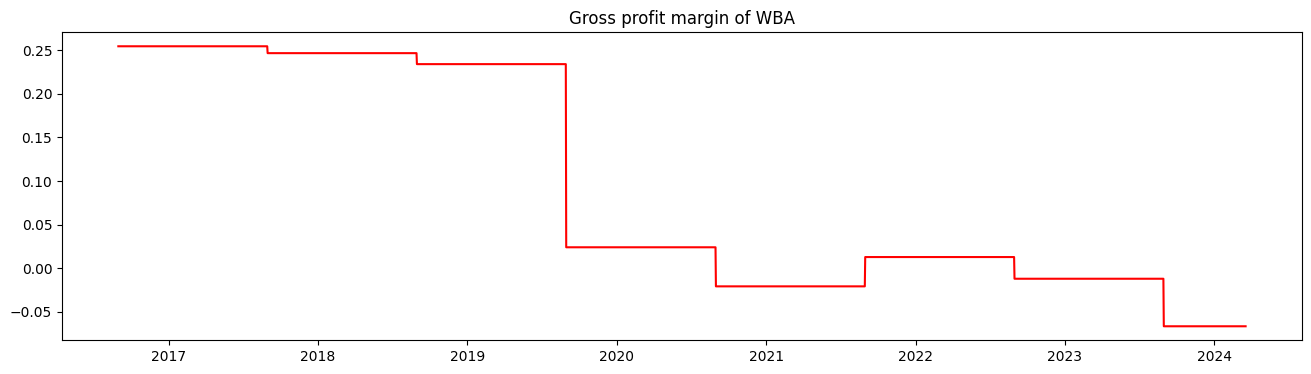

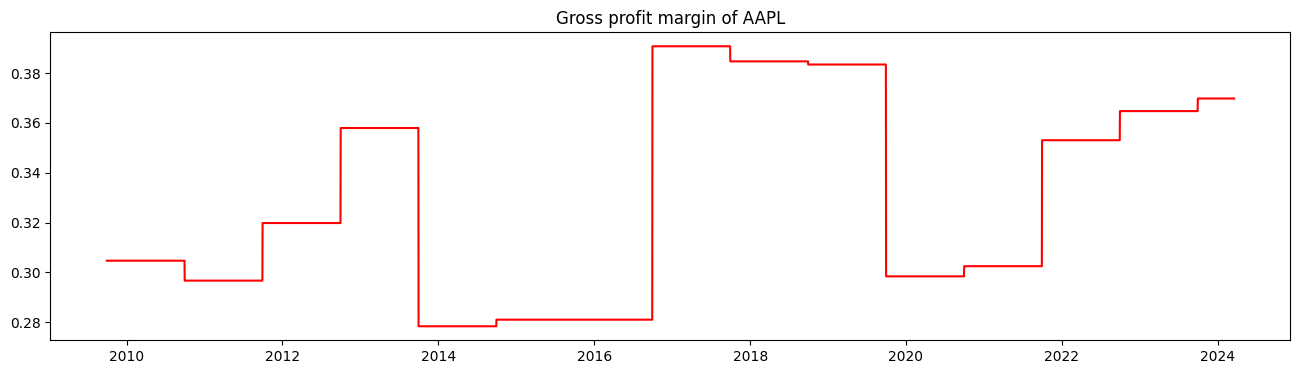

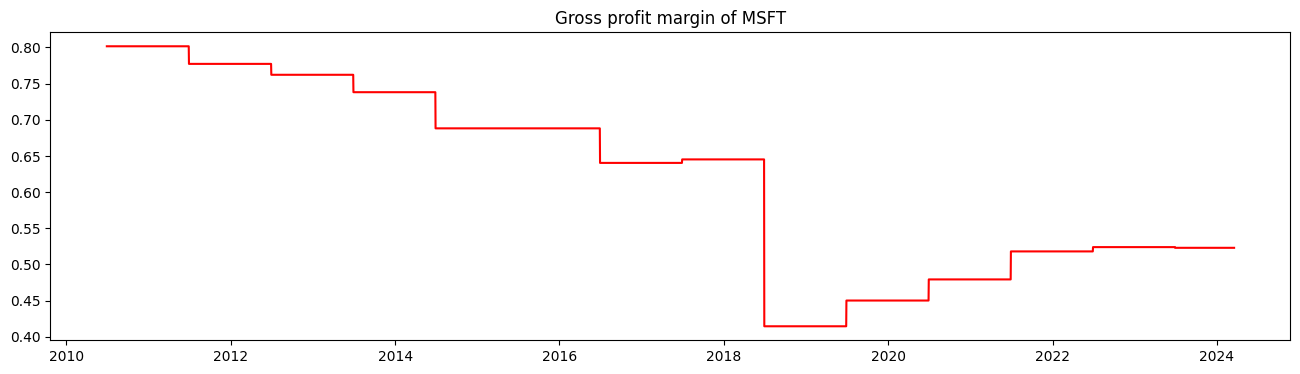

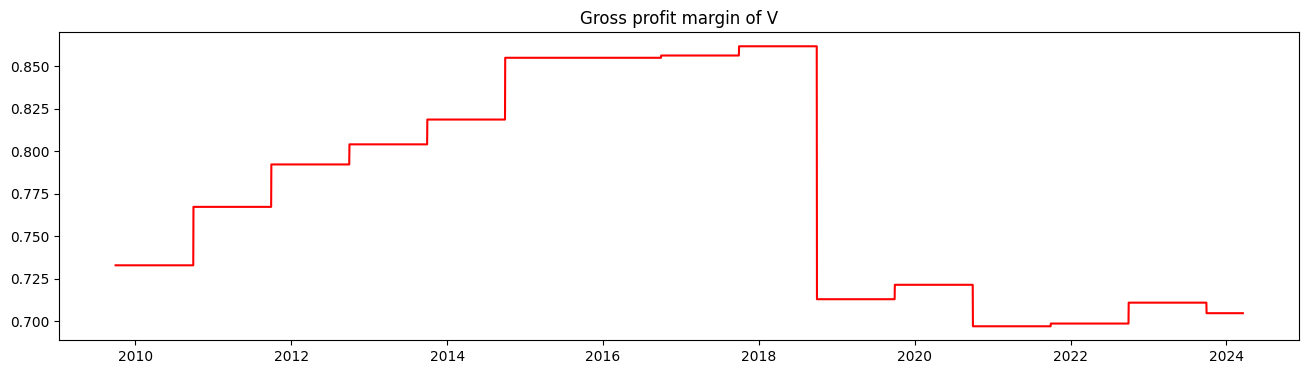

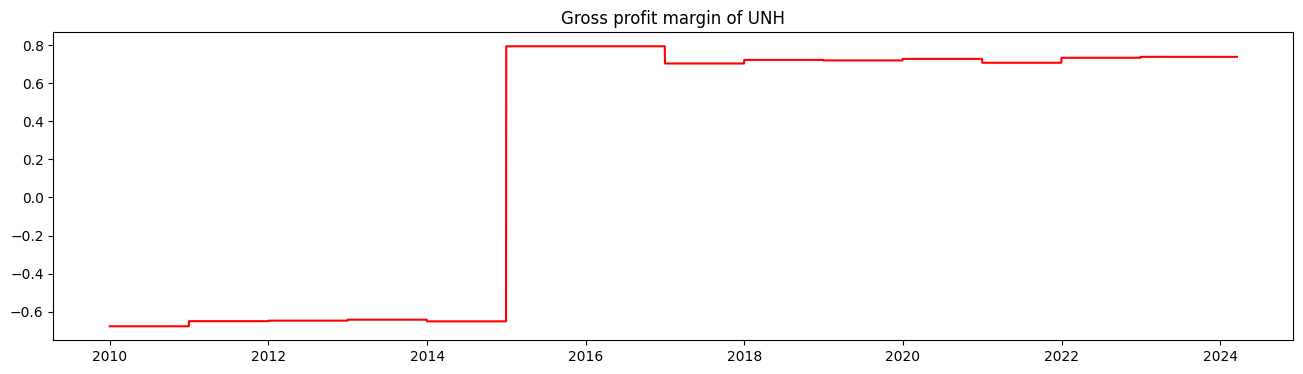

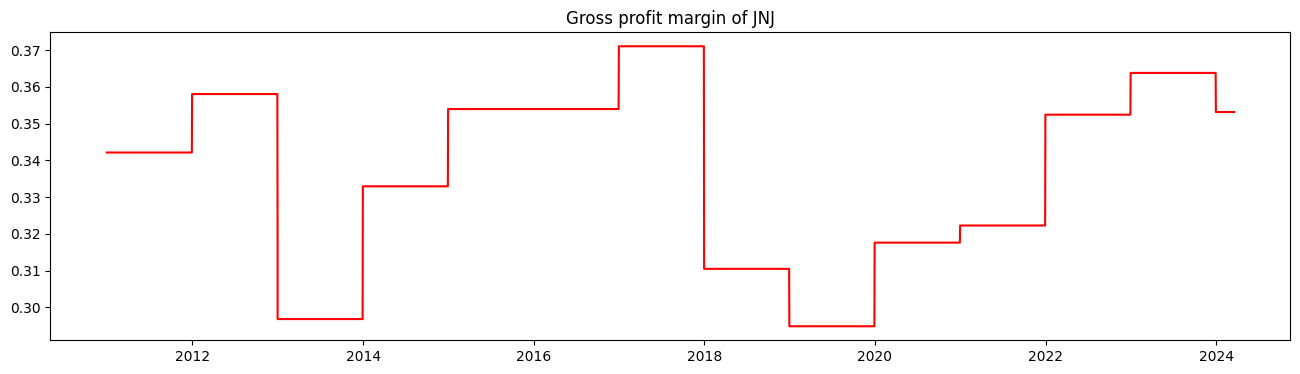

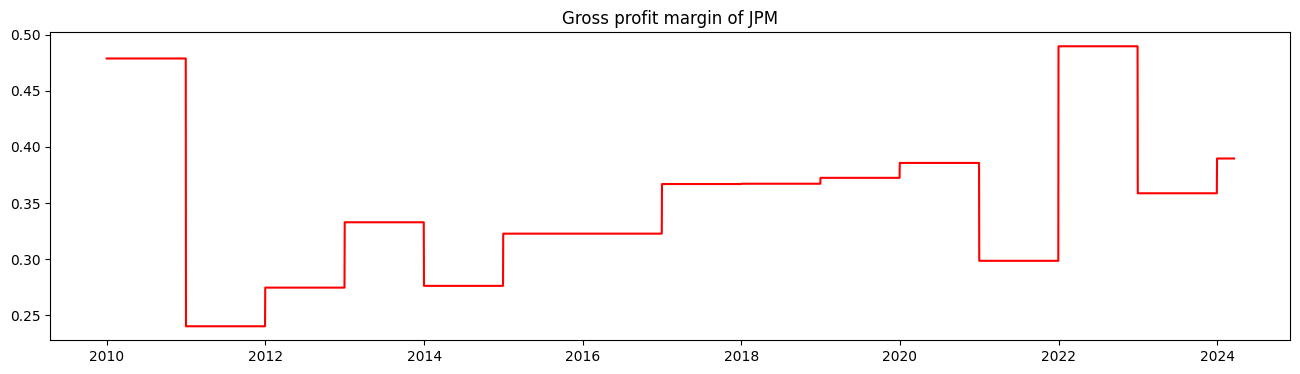

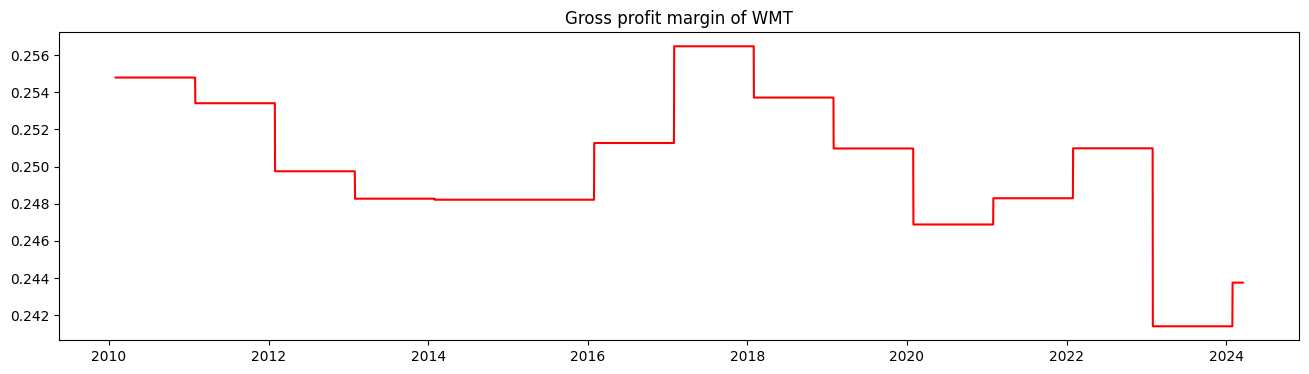

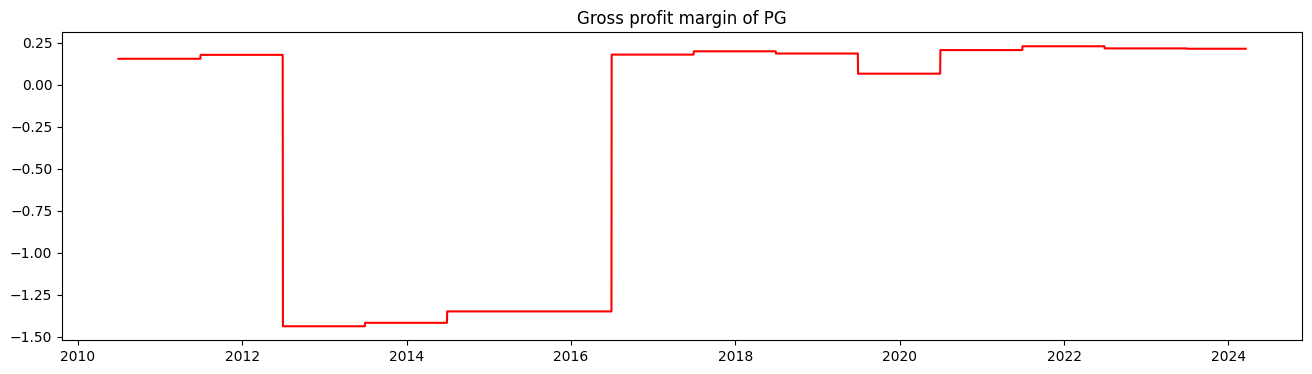

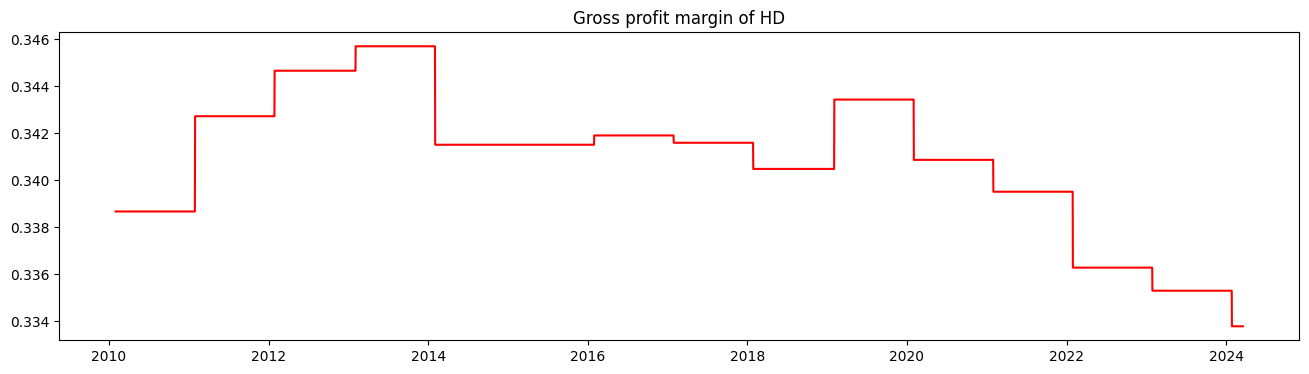

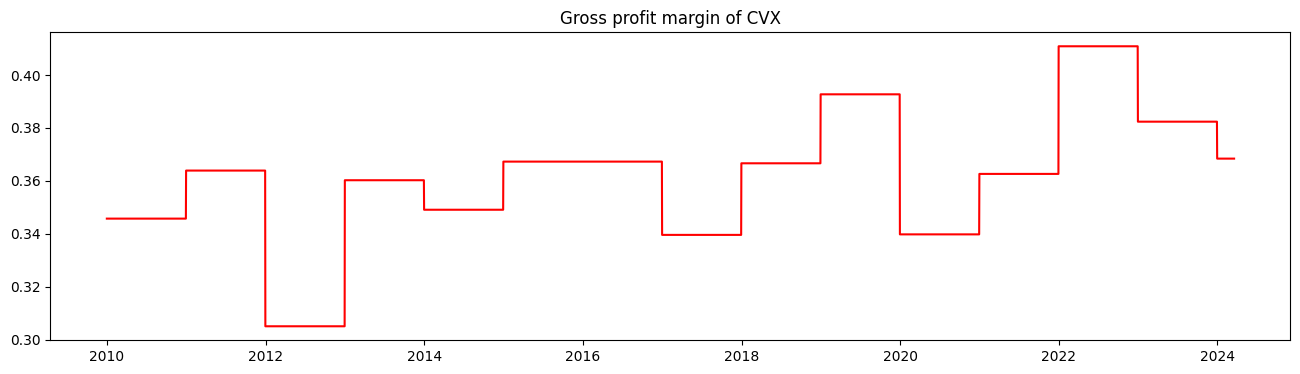

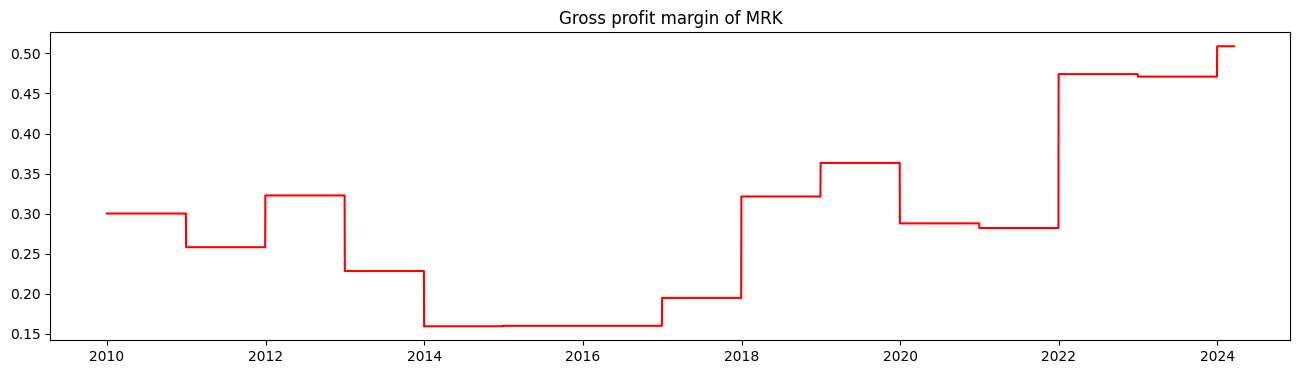

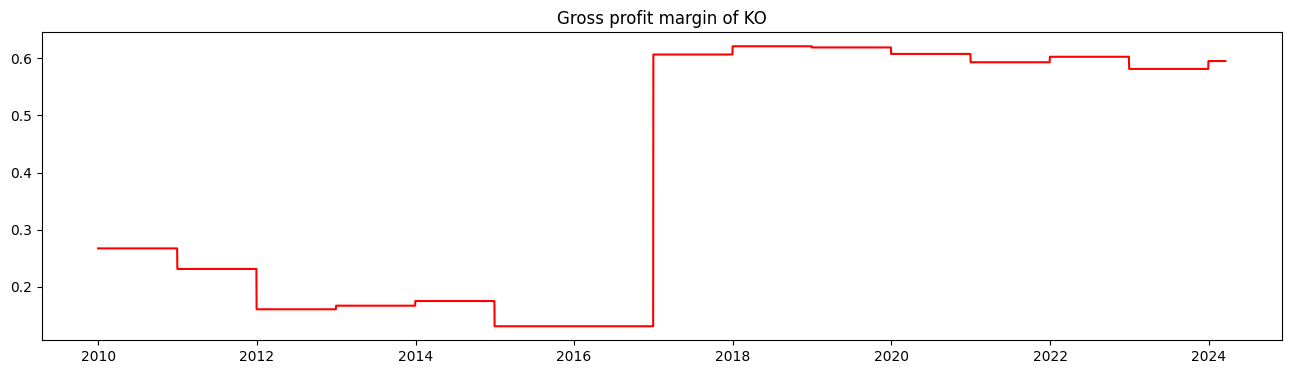

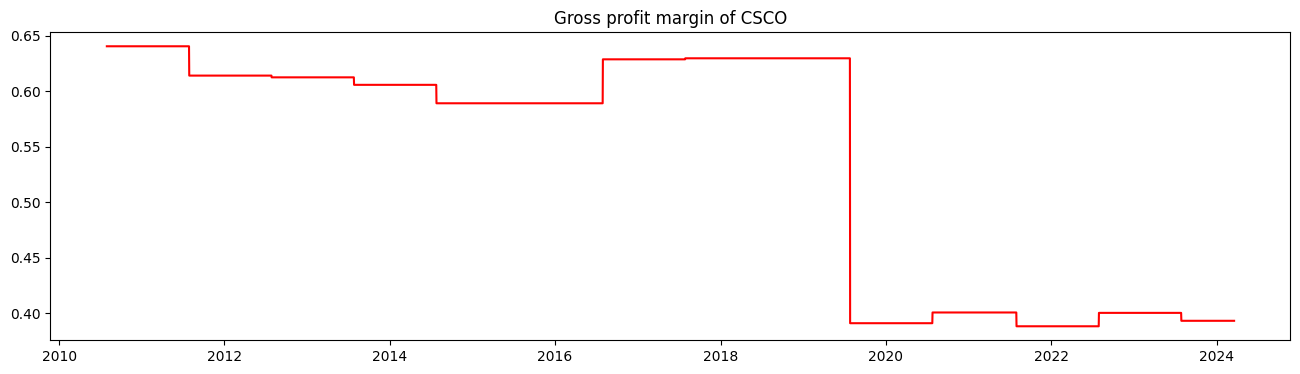

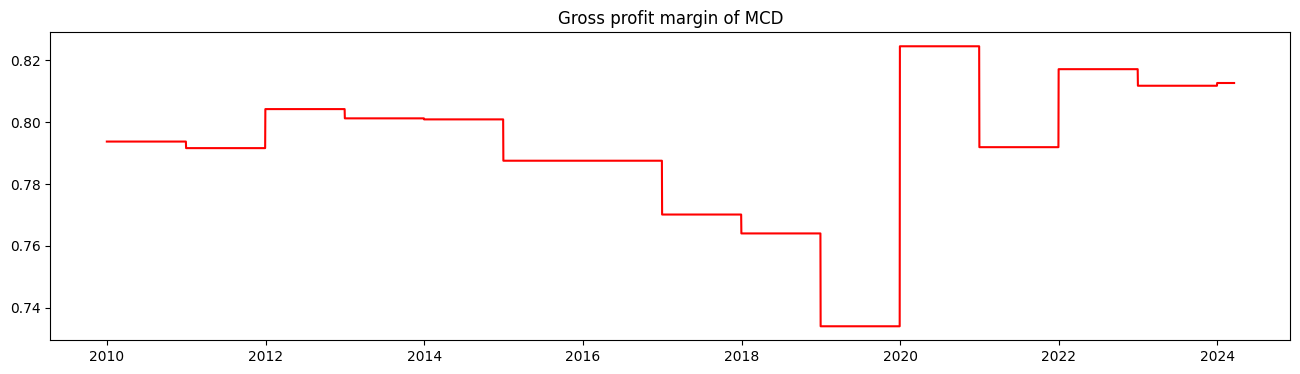

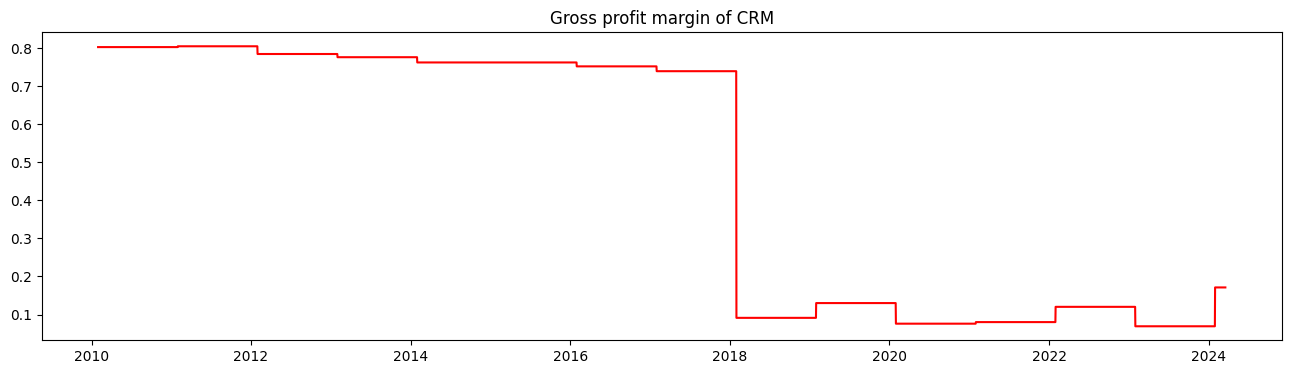

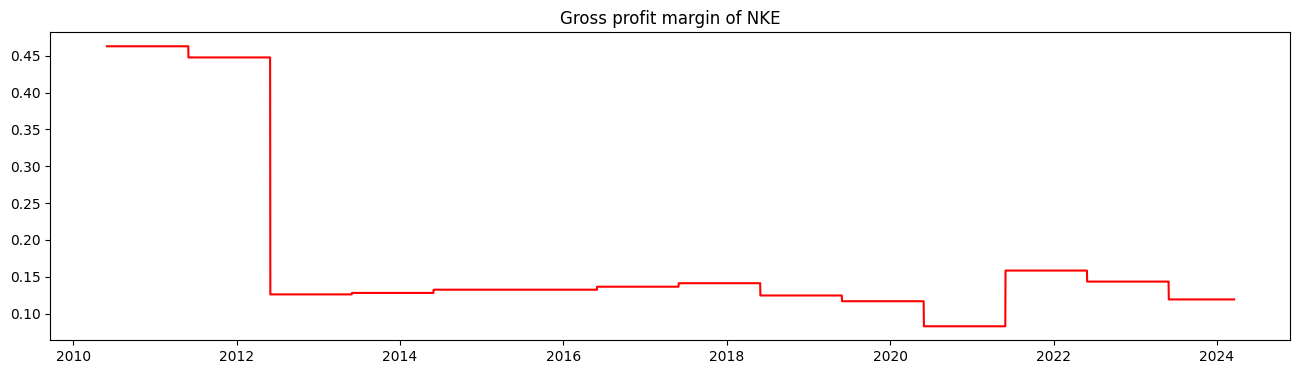

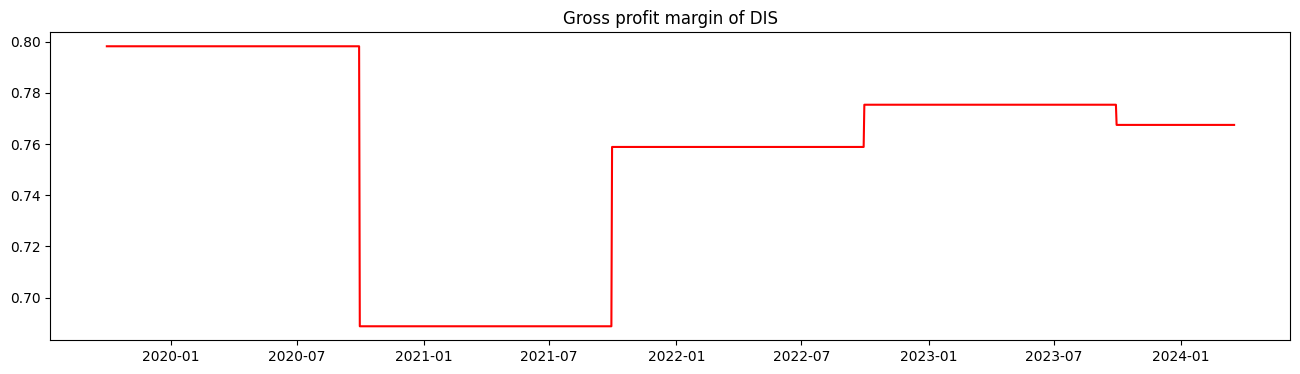

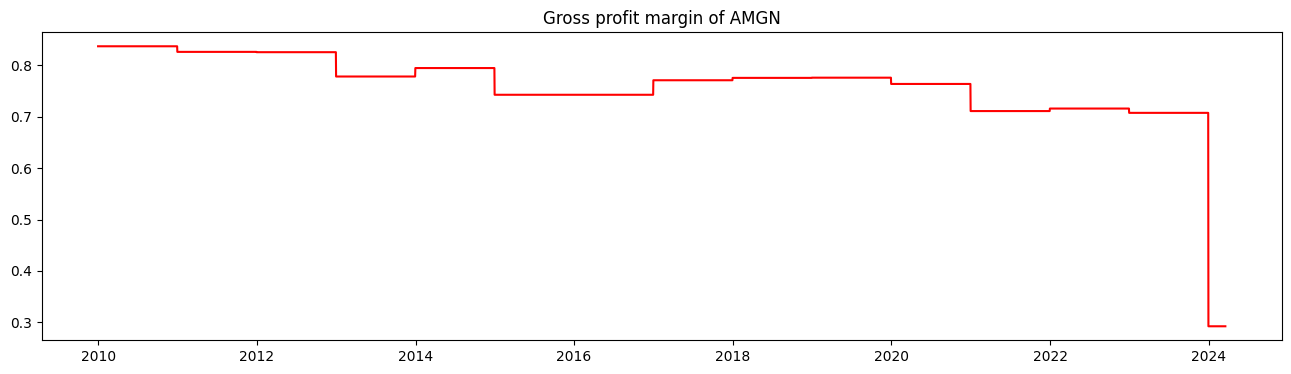

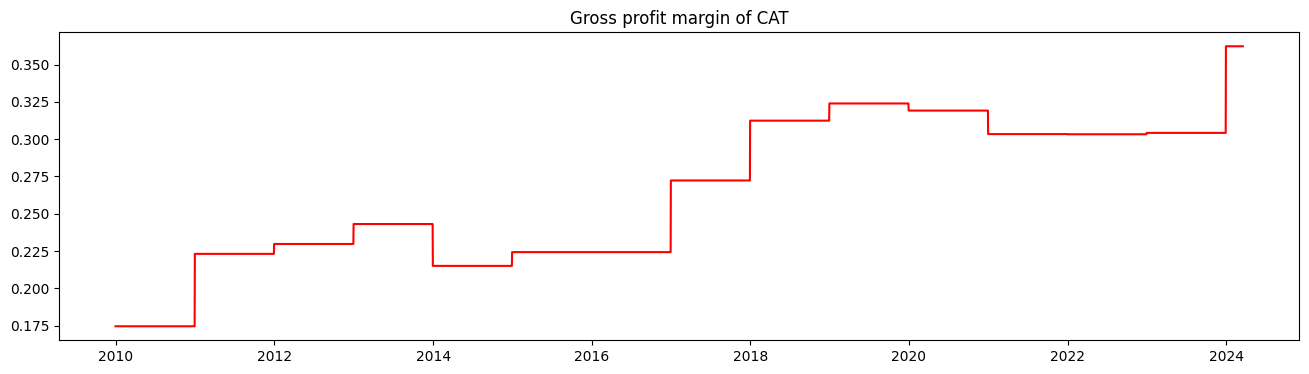

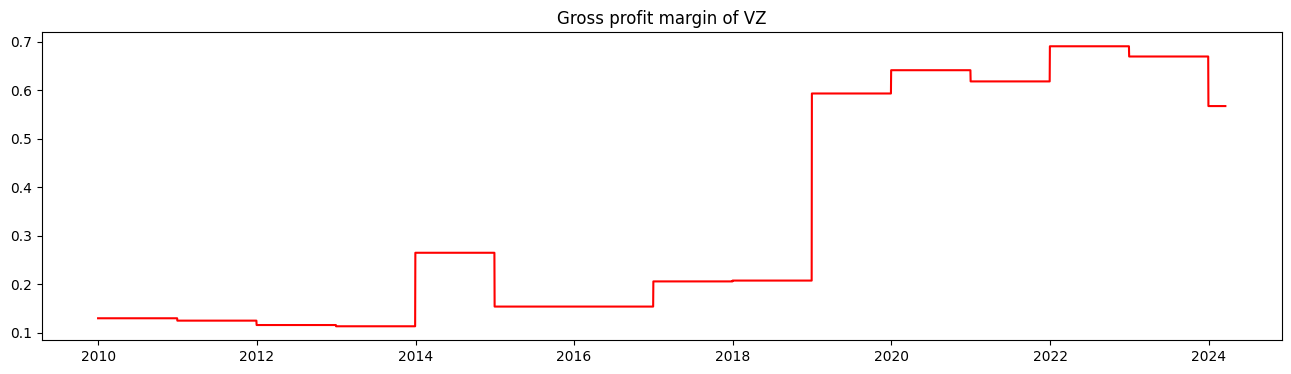

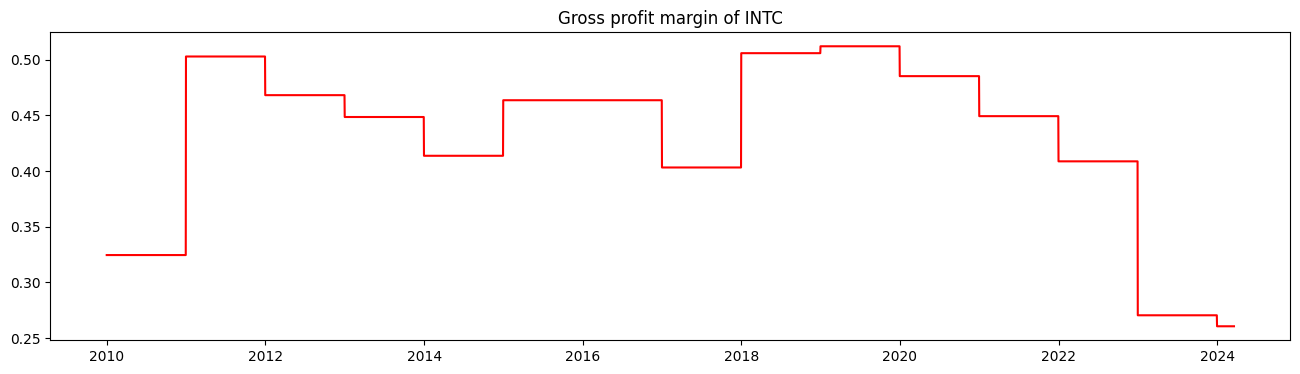

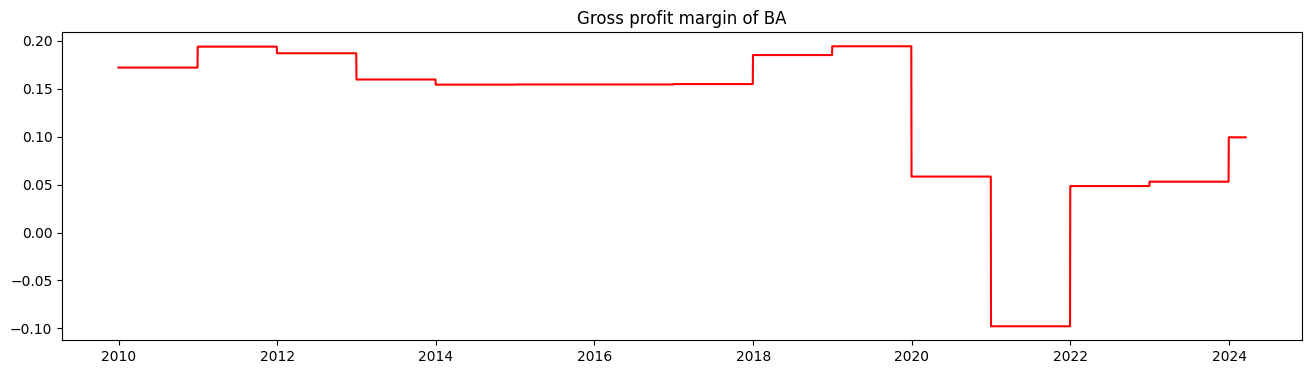

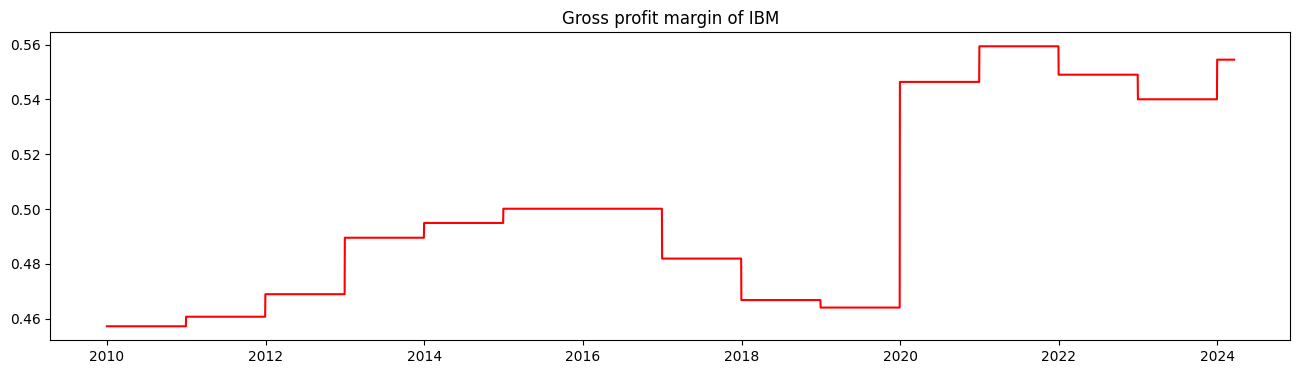

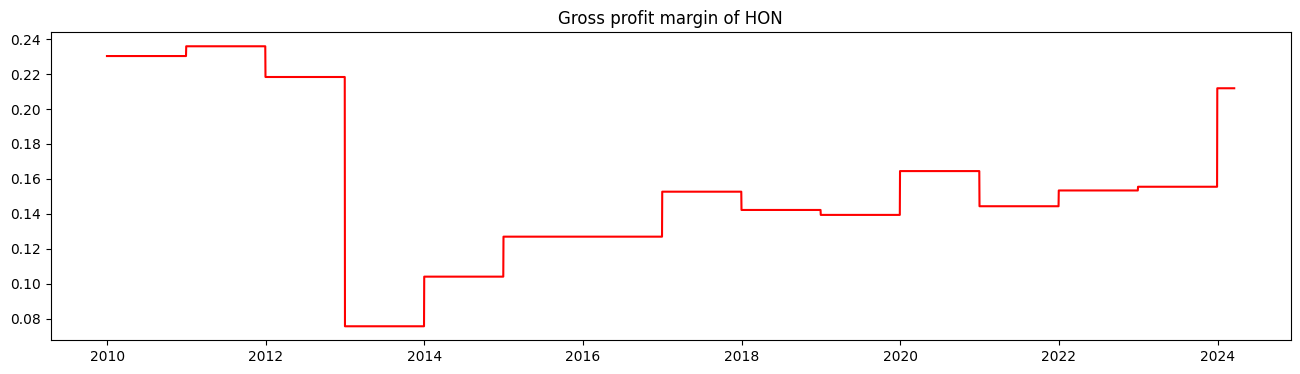

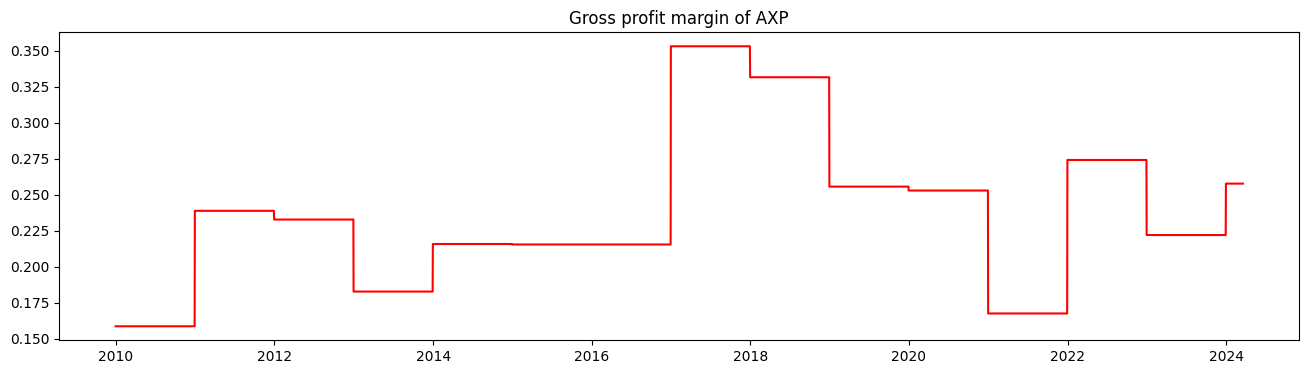

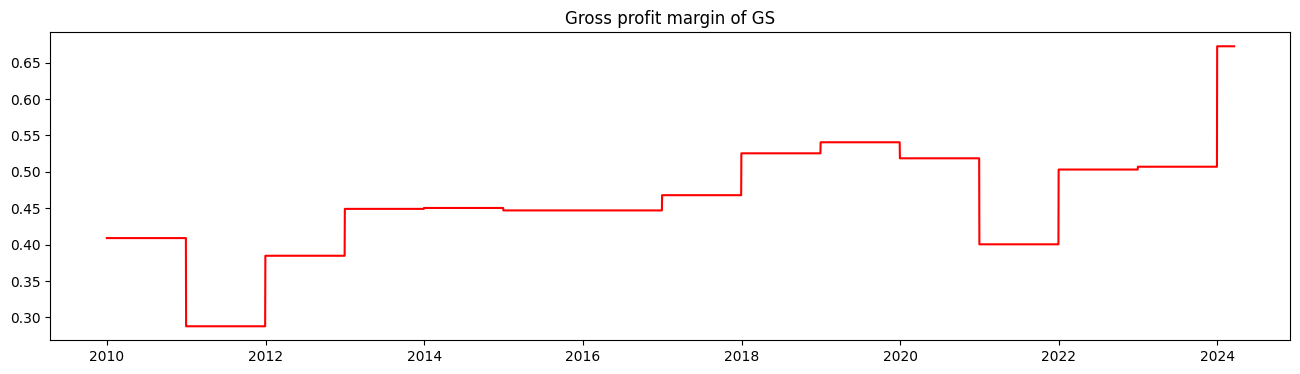

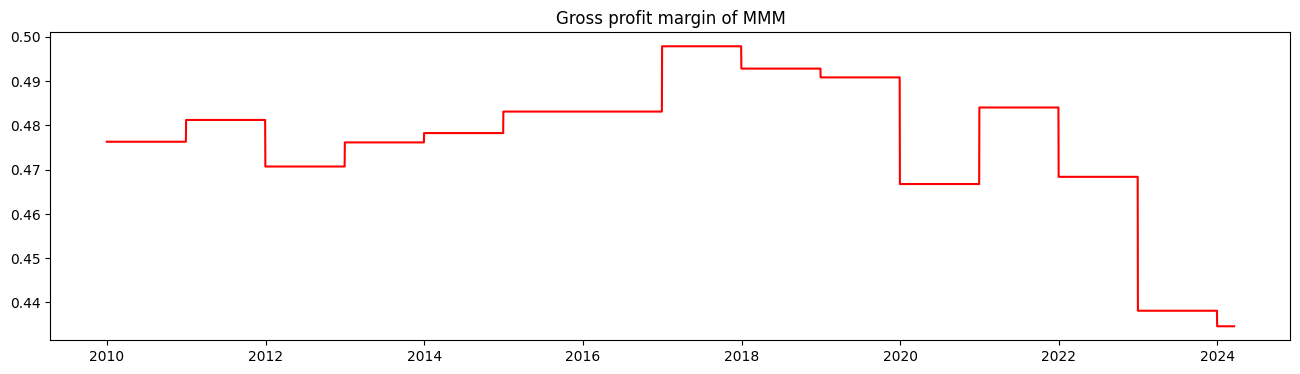

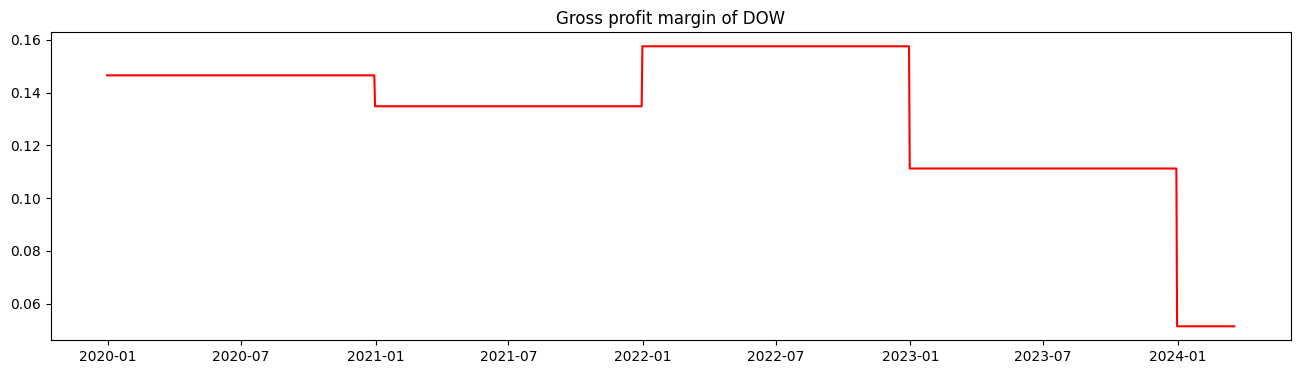

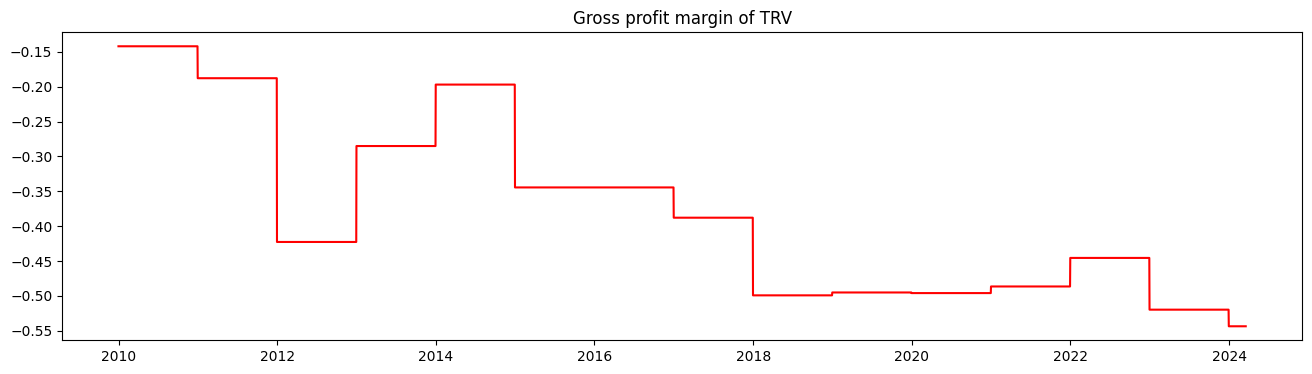

In [61]:
daily_ratios = pd.DataFrame()
for ticket in ratios.tic.unique():
    # Interpolate data for each ticket
    one_tic_ratios = pd.merge(date_range,ratios[ratios.tic == ticket],how="left",on=['date'])
    one_tic_ratios['tic'] = ticket
    one_tic_ratios.ffill(axis=0, inplace=True)
    daily_ratios = pd.concat([daily_ratios, one_tic_ratios], ignore_index=True)

    # Check data by drawing it out
    %matplotlib inline
    plt.figure(figsize=(16, 4)) 
    plt.plot(one_tic_ratios.date, one_tic_ratios.gross_profit_margin, color = 'red')
    plt.title(f'Gross profit margin of {ticket}')
    plt.show()

In [62]:
daily_ratios.dropna(subset='gross_profit_margin',inplace=True)
daily_ratios.reset_index(inplace=True,drop=True)
daily_ratios

date  tic       close        profit  common_stock  \
0      2016-08-31  WBA   60.654716  4.371000e+09  1.082500e+09   
1      2016-09-01  WBA   60.654716  4.371000e+09  1.082500e+09   
2      2016-09-02  WBA   60.654716  4.371000e+09  1.082500e+09   
3      2016-09-03  WBA   60.654716  4.371000e+09  1.082500e+09   
4      2016-09-04  WBA   60.654716  4.371000e+09  1.082500e+09   
...           ...  ...         ...           ...           ...   
145112 2024-03-14  TRV  190.552353 -2.842100e+10  2.282000e+08   
145113 2024-03-15  TRV  190.552353 -2.842100e+10  2.282000e+08   
145114 2024-03-16  TRV  190.552353 -2.842100e+10  2.282000e+08   
145115 2024-03-17  TRV  190.552353 -2.842100e+10  2.282000e+08   
145116 2024-03-18  TRV  190.552353 -2.842100e+10  2.282000e+08   

        total_liabilities         eps      dividend            bv  \
0            4.280800e+10    4.037875  2.715000e+09 -1.444200e+10   
1            4.280800e+10    4.037875  2.715000e+09 -1.444200e+10   
2            4.280800e+10    4.037875  2.715000e+09 -1.444200e+10   
3            4.280800e+10    4.037875  2.715000e+09 -1.444200e+10   
4            4.280800e+10    4.037875  2.715000e+09 -1.444200e+10   
...                   ...         ...           ...           ...   
145112       1.010570e+11 -124.544259  1.866000e+09 -6.435200e+10   
145113       1.010570e+11 -124.544259  1.866000e+09 -6.435200e+10   
145114       1.010570e+11 -124.544259  1.866000e+09 -6.435200e+10   
145115       1.010570e+11 -124.544259  1.866000e+09 -6.435200e+10   
145116       1.010570e+11 -124.544259  1.866000e+09 -6.435200e+10   

        gross_profit_margin  ...  capital_cost_on_ebit  eps_on_mp  \
0                  0.254570  ...              0.222166   0.066571   
1                  0.254570  ...              0.222166   0.066571   
2                  0.254570  ...              0.222166   0.066571   
3                  0.254570  ...              0.222166   0.066571   
4                  0.254570  ...              0.222166   0.066571   
...                     ...  ...                   ...        ...   
145112            -0.543685  ...             -0.000000  -0.653596   
145113            -0.543685  ...             -0.000000  -0.653596   
145114            -0.543685  ...             -0.000000  -0.653596   
145115            -0.543685  ...             -0.000000  -0.653596   
145116            -0.543685  ...             -0.000000  -0.653596   

        dividend_on_mp      mp_on_bv  trend_gross_margin  trend_profit_margin  \
0         4.476156e+07 -4.199883e-09           -0.001351             0.003741   
1         4.476156e+07 -4.199883e-09           -0.001351             0.003741   
2         4.476156e+07 -4.199883e-09           -0.001351             0.003741   
3         4.476156e+07 -4.199883e-09           -0.001351             0.003741   
4         4.476156e+07 -4.199883e-09           -0.001351             0.003741   
...                ...           ...                 ...                  ...   
145112    9.792584e+06 -2.961094e-09           -0.032695            -0.024844   
145113    9.792584e+06 -2.961094e-09           -0.032695            -0.024844   
145114    9.792584e+06 -2.961094e-09           -0.032695            -0.024844   
145115    9.792584e+06 -2.961094e-09           -0.032695            -0.024844   
145116    9.792584e+06 -2.961094e-09           -0.032695            -0.024844   

        fluc_sga  fluc_dep_ratio  fluc_inv_on_ebit  fluc_rec_on_rev  
0       0.018464        0.002538          0.245945         0.006433  
1       0.018464        0.002538          0.245945         0.006433  
2       0.018464        0.002538          0.245945         0.006433  
3       0.018464        0.002538          0.245945         0.006433  
4       0.018464        0.002538          0.245945         0.006433  
...          ...             ...               ...              ...  
145112  0.026111        0.000000          1.261784         0.000347  
145113  0.026111        0.000

<a id='3.4'></a>
## 4.4 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [63]:
daily_ratios.drop(columns=['close'],inplace=True)

In [64]:
df_date = pd.DataFrame(df)[['date','tic','close']]
df_date.columns = ['date','tic','close']
df_date['date'] = pd.to_datetime(df_date.date)
final_ratios = pd.merge(daily_ratios,df_date,how="left",on=['date','tic'])
final_ratios

date  tic        profit  common_stock  total_liabilities  \
0      2016-08-31  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
1      2016-09-01  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
2      2016-09-02  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
3      2016-09-03  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
4      2016-09-04  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
...           ...  ...           ...           ...                ...   
145112 2024-03-14  TRV -2.842100e+10  2.282000e+08       1.010570e+11   
145113 2024-03-15  TRV -2.842100e+10  2.282000e+08       1.010570e+11   
145114 2024-03-16  TRV -2.842100e+10  2.282000e+08       1.010570e+11   
145115 2024-03-17  TRV -2.842100e+10  2.282000e+08       1.010570e+11   
145116 2024-03-18  TRV -2.842100e+10  2.282000e+08       1.010570e+11   

               eps      dividend            bv  gross_profit_margin  \
0         4.037875  2.715000e+09 -1.444200e+10             0.254570   
1         4.037875  2.715000e+09 -1.444200e+10             0.254570   
2         4.037875  2.715000e+09 -1.444200e+10             0.254570   
3         4.037875  2.715000e+09 -1.444200e+10             0.254570   
4         4.037875  2.715000e+09 -1.444200e+10             0.254570   
...            ...           ...           ...                  ...   
145112 -124.544259  1.866000e+09 -6.435200e+10            -0.543685   
145113 -124.544259  1.866000e+09 -6.435200e+10            -0.543685   
145114 -124.544259  1.866000e+09 -6.435200e+10            -0.543685   
145115 -124.544259  1.866000e+09 -6.435200e+10            -0.543685   
145116 -124.544259  1.866000e+09 -6.435200e+10            -0.543685   

        sga_ratio  ...  eps_on_mp  dividend_on_mp      mp_on_bv  \
0        0.800362  ...   0.066571    4.476156e+07 -4.199883e-09   
1        0.800362  ...   0.066571    4.476156e+07 -4.199883e-09   
2        0.800362  ...   0.066571    4.476156e+07 -4.199883e-09   
3        0.800362  ...   0.066571    4.476156e+07 -4.199883e-09   
4        0.800362  ...   0.066571    4.476156e+07 -4.199883e-09   
...           ...  ...        ...             ...           ...   
145112  -0.230157  ...  -0.653596    9.792584e+06 -2.961094e-09   
145113  -0.230157  ...  -0.653596    9.792584e+06 -2.961094e-09   
145114  -0.230157  ...  -0.653596    9.792584e+06 -2.961094e-09   
145115  -0.230157  ...  -0.653596    9.792584e+06 -2.961094e-09   
145116  -0.230157  ...  -0.653596    9.792584e+06 -2.961094e-09   

        trend_gross_margin  trend_profit_margin  fluc_sga  fluc_dep_ratio  \
0                -0.001351             0.003741  0.018464        0.002538   
1                -0.001351             0.003741  0.018464        0.002538   
2                -0.001351             0.003741  0.018464        0.002538   
3                -0.001351             0.003741  0.018464        0.002538   
4                -0.001351             0.003741  0.018464        0.002538   
...                    ...                  ...       ...             ...   
145112           -0.032695            -0.024844  0.026111        0.000000   
145113           -0.032695            -0.024844  0.026111        0.000000   
145114           -0.032695            -0.024844  0.026111        0.000000   
145115           -0.032695            -0.024844  0.026111        0.000000   
145116           -0.032695            -0.024844  0.026111        0.000000   

        fluc_inv_on_ebit  fluc_rec_on_rev       close  
0               0.245945         0.006433   60.654716  
1               0.245945         0.006433   61.278481  
2               0.245945         0.006433   61.789505  
3               0.245945         0.006433         NaN  
4               0.245945         0.006433         NaN  
...                  ...              ...         ...  
145112          1.261784         0.000347  221.419998  
145113          1.261784         0.000347  220.929993  
145114          1.261784         0.000347        

In [65]:
final_ratios.dropna(subset=['close'],inplace=True,how='any')
final_ratios.reset_index(drop=True,inplace=True)
final_ratios.isna().sum()

date                     0
tic                      0
profit                   0
common_stock             0
total_liabilities        0
eps                      0
dividend                 0
bv                       0
gross_profit_margin      0
sga_ratio                0
dep_ratio                0
ebit_on_int              0
profit_margin            0
count_positive_profit    0
csti_on_liabilities      0
inventory_on_ebit        0
receivable_on_rev        0
roa                      0
roe                      0
debt_on_min_ebit         0
liabilities_on_equity    0
capital_cost_on_ebit     0
eps_on_mp                0
dividend_on_mp           0
mp_on_bv                 0
trend_gross_margin       0
trend_profit_margin      0
fluc_sga                 0
fluc_dep_ratio           0
fluc_inv_on_ebit         0
fluc_rec_on_rev          0
close                    0
dtype: int64

In [66]:
final_ratios

date  tic        profit  common_stock  total_liabilities  \
0     2016-08-31  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
1     2016-09-01  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
2     2016-09-02  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
3     2016-09-06  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
4     2016-09-07  WBA  4.371000e+09  1.082500e+09       4.280800e+10   
...          ...  ...           ...           ...                ...   
99951 2024-03-12  TRV -2.842100e+10  2.282000e+08       1.010570e+11   
99952 2024-03-13  TRV -2.842100e+10  2.282000e+08       1.010570e+11   
99953 2024-03-14  TRV -2.842100e+10  2.282000e+08       1.010570e+11   
99954 2024-03-15  TRV -2.842100e+10  2.282000e+08       1.010570e+11   
99955 2024-03-18  TRV -2.842100e+10  2.282000e+08       1.010570e+11   

              eps      dividend            bv  gross_profit_margin  sga_ratio  \
0        4.037875  2.715000e+09 -1.444200e+10             0.254570   0.800362   
1        4.037875  2.715000e+09 -1.444200e+10             0.254570   0.800362   
2        4.037875  2.715000e+09 -1.444200e+10             0.254570   0.800362   
3        4.037875  2.715000e+09 -1.444200e+10             0.254570   0.800362   
4        4.037875  2.715000e+09 -1.444200e+10             0.254570   0.800362   
...           ...           ...           ...                  ...        ...   
99951 -124.544259  1.866000e+09 -6.435200e+10            -0.543685  -0.230157   
99952 -124.544259  1.866000e+09 -6.435200e+10            -0.543685  -0.230157   
99953 -124.544259  1.866000e+09 -6.435200e+10            -0.543685  -0.230157   
99954 -124.544259  1.866000e+09 -6.435200e+10            -0.543685  -0.230157   
99955 -124.544259  1.866000e+09 -6.435200e+10            -0.543685  -0.230157   

       ...  eps_on_mp  dividend_on_mp      mp_on_bv  trend_gross_margin  \
0      ...   0.066571    4.476156e+07 -4.199883e-09           -0.001351   
1      ...   0.066571    4.476156e+07 -4.199883e-09           -0.001351   
2      ...   0.066571    4.476156e+07 -4.199883e-09           -0.001351   
3      ...   0.066571    4.476156e+07 -4.199883e-09           -0.001351   
4      ...   0.066571    4.476156e+07 -4.199883e-09           -0.001351   
...    ...        ...             ...           ...                 ...   
99951  ...  -0.653596    9.792584e+06 -2.961094e-09           -0.032695   
99952  ...  -0.653596    9.792584e+06 -2.961094e-09           -0.032695   
99953  ...  -0.653596    9.792584e+06 -2.961094e-09           -0.032695   
99954  ...  -0.653596    9.792584e+06 -2.961094e-09           -0.032695   
99955  ...  -0.653596    9.792584e+06 -2.961094e-09           -0.032695   

       trend_profit_margin  fluc_sga  fluc_dep_ratio  fluc_inv_on_ebit  \
0                 0.003741  0.018464        0.002538          0.245945   
1                 0.003741  0.018464        0.002538          0.245945   
2                 0.003741  0.018464        0.002538          0.245945   
3                 0.003741  0.018464        0.002538          0.245945   
4                 0.003741  0.018464        0.002538          0.245945   
...                    ...       ...             ...               ...   
99951            -0.024844  0.026111        0.000000          1.261784   
99952            -0.024844  0.026111        0.000000          1.261784   
99953            -0.024844  0.026111        0.000000          1.261784   
99954            -0.024844  0.026111        0.000000          1.261784   
99955            -0.024844  0.026111        0.000000          1.261784   

       fluc_rec_on_rev       close  
0             0.006433   60.654716  
1             0.006433   61.278481  
2             0.006433   61.789505  
3             0.006433   61.353630  
4             0.006433   62.285503  
...                ...         ...  
99951         0.000347  220.460007  
99952         0.000347  223.490005  
99953         0.000347  221.419998  
99954         

In [67]:
def compute_market_ratios(df_final):
    
    market_equity = df_final.common_stock * df_final.close
    market_asset = df_final.total_liabilities + market_equity

    # ROA
    roa = (df_final.profit / market_asset).to_frame('roa')
    
    # ROE
    roe = (df_final.profit / market_equity).to_frame('roe')
    
    # Total Liabilities / Total Equity
    liabilities_on_equity = (df_final.total_liabilities / market_equity).to_frame('liabilities_on_equity')
    
    # EPS / MP
    eps_on_mp = (df_final.eps / df_final.close).to_frame('eps_on_mp')
    
    # Cash and Stock Dividend & Repurchase Common / MP
    dividend_on_mp = (df_final.dividend / market_equity).to_frame('dividend_on_mp')
    
    # MP / BV
    mp_on_bv = (market_equity / df_final.bv).to_frame('mp_on_bv')
    
    # Create a dataframe that merges all the ratios
    ratios = pd.concat([roa,roe,liabilities_on_equity,eps_on_mp,dividend_on_mp,mp_on_bv], axis=1)
    
    return ratios

In [68]:
market_ratios = compute_market_ratios(final_ratios)

In [69]:
ratios = final_ratios.drop(columns=['roa','roe','liabilities_on_equity','eps_on_mp','dividend_on_mp','mp_on_bv'])
ratios = pd.concat([ratios,market_ratios],axis=1)

In [70]:
columns = ['date', 'tic', 'close', 'profit', 'common_stock', 'total_liabilities', 'eps',
        'dividend', 'bv', 'gross_profit_margin', 'sga_ratio', 'dep_ratio','ebit_on_int', 'profit_margin', 
        'count_positive_profit','csti_on_liabilities', 'inventory_on_ebit', 'receivable_on_rev','roa', 'roe', 'liabilities_on_equity',
        'debt_on_min_ebit', 'capital_cost_on_ebit','eps_on_mp', 'dividend_on_mp', 'mp_on_bv', 'trend_gross_margin',
        'trend_profit_margin', 'fluc_sga', 'fluc_dep_ratio', 'fluc_inv_on_ebit','fluc_rec_on_rev']
ratios = ratios[columns]
ratios.columns

Index(['date', 'tic', 'close', 'profit', 'common_stock', 'total_liabilities',
       'eps', 'dividend', 'bv', 'gross_profit_margin', 'sga_ratio',
       'dep_ratio', 'ebit_on_int', 'profit_margin', 'count_positive_profit',
       'csti_on_liabilities', 'inventory_on_ebit', 'receivable_on_rev', 'roa',
       'roe', 'liabilities_on_equity', 'debt_on_min_ebit',
       'capital_cost_on_ebit', 'eps_on_mp', 'dividend_on_mp', 'mp_on_bv',
       'trend_gross_margin', 'trend_profit_margin', 'fluc_sga',
       'fluc_dep_ratio', 'fluc_inv_on_ebit', 'fluc_rec_on_rev'],
      dtype='object')

In [71]:
ratios.drop(columns=['profit', 'common_stock', 'total_liabilities','eps', 'dividend', 'bv'],inplace=True)

In [72]:
ratios

date  tic       close  gross_profit_margin  sga_ratio  dep_ratio  \
0     2016-08-31  WBA   60.654716             0.254570   0.800362   0.043516   
1     2016-09-01  WBA   61.278481             0.254570   0.800362   0.043516   
2     2016-09-02  WBA   61.789505             0.254570   0.800362   0.043516   
3     2016-09-06  WBA   61.353630             0.254570   0.800362   0.043516   
4     2016-09-07  WBA   62.285503             0.254570   0.800362   0.043516   
...          ...  ...         ...                  ...        ...        ...   
99951 2024-03-12  TRV  220.460007            -0.543685  -0.230157  -0.000000   
99952 2024-03-13  TRV  223.490005            -0.543685  -0.230157  -0.000000   
99953 2024-03-14  TRV  221.419998            -0.543685  -0.230157  -0.000000   
99954 2024-03-15  TRV  220.929993            -0.543685  -0.230157  -0.000000   
99955 2024-03-18  TRV  221.919998            -0.543685  -0.230157  -0.000000   

       ebit_on_int  profit_margin  count_positive_profit  csti_on_liabilities  \
0        10.006711       0.037247                    0.5             0.229840   
1        10.006711       0.037247                    0.5             0.229840   
2        10.006711       0.037247                    0.5             0.229840   
3        10.006711       0.037247                    0.5             0.229840   
4        10.006711       0.037247                    0.5             0.229840   
...            ...            ...                    ...                  ...   
99951   -73.577128      -0.687095                    0.8             0.057265   
99952   -73.577128      -0.687095                    0.8             0.057265   
99953   -73.577128      -0.687095                    0.8             0.057265   
99954   -73.577128      -0.687095                    0.8             0.057265   
99955   -73.577128      -0.687095                    0.8             0.057265   

       ...  capital_cost_on_ebit  eps_on_mp  dividend_on_mp  mp_on_bv  \
0      ...              0.222166   0.066571        0.041350 -4.546374   
1      ...              0.222166   0.065894        0.040929 -4.593128   
2      ...              0.222166   0.065349        0.040591 -4.631432   
3      ...              0.222166   0.065813        0.040879 -4.598761   
4      ...              0.222166   0.064828        0.040268 -4.668609   
...    ...                   ...        ...             ...       ...   
99951  ...             -0.000000  -0.564929        0.037091 -0.781778   
99952  ...             -0.000000  -0.557270        0.036588 -0.792523   
99953  ...             -0.000000  -0.562480        0.036930 -0.785182   
99954  ...             -0.000000  -0.563727        0.037012 -0.783445   
99955  ...             -0.000000  -0.561212        0.036847 -0.786955   

       trend_gross_margin  trend_profit_margin  fluc_sga  fluc_dep_ratio  \
0               -0.001351             0.003741  0.018464        0.002538   
1               -0.001351             0.003741  0.018464        0.002538   
2               -0.001351             0.003741  0.018464        0.002538   
3               -0.001351             0.003741  0.018464        0.002538   
4               -0.001351             0.003741  0.018464        0.002538   
...                   ...                  ...       ...             ...   
99951           -0.032695            -0.024844  0.026111        0.000000   
99952           -0.032695            -0.024844  0.026111        0.000000   
99953           -0.032695            -0.024844  0.026111        0.000000   
99954           -0.032695            -0.024844  0.026111        0.000000   
99955           -0.032695            -0.024844  0.026111        0.000000   

       fluc_inv_on_ebit  fluc_rec_on_rev  
0              0.245945         0.006433  
1              0.245945         0.006433  
2              0.245945         0.006433  
3              0.245945         0.006433  
4              0.245945         0.006433  
...                 ...       

In [73]:
ratios.to_csv('./' + DATA_SAVE_DIR + '/dow30_ready_with_filter_data_daily.csv')

<a id='3.5'></a>
## 4.5 Finish data preparation

<a id='3.5.1'></a>
### 4.5.1 Load available data

In [79]:
# If the data is available in the data storage, load processed_full from readied data
processed_full = pd.read_csv('./' + DATA_SAVE_DIR + '/dow30_ready_with_filter_data_daily.csv',index_col=0)
processed_full['date'] = pd.to_datetime(processed_full.date,format='mixed')
processed_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99956 entries, 0 to 99955
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   99956 non-null  datetime64[ns]
 1   tic                    99956 non-null  object        
 2   close                  99956 non-null  float64       
 3   gross_profit_margin    99956 non-null  float64       
 4   sga_ratio              99956 non-null  float64       
 5   dep_ratio              99956 non-null  float64       
 6   ebit_on_int            99956 non-null  float64       
 7   profit_margin          99956 non-null  float64       
 8   count_positive_profit  99956 non-null  float64       
 9   csti_on_liabilities    99956 non-null  float64       
 10  inventory_on_ebit      99956 non-null  float64       
 11  receivable_on_rev      99956 non-null  float64       
 12  roa                    99956 non-null  float64       
 13  roe   

In [80]:
processed_full = processed_full[processed_full.tic.isin(DOW_30_TICKER)]
processed_full.tic.unique()

array(['WBA', 'AAPL', 'MSFT', 'V', 'UNH', 'JNJ', 'JPM', 'WMT', 'PG', 'HD',
       'CVX', 'MRK', 'KO', 'CSCO', 'MCD', 'CRM', 'NKE', 'DIS', 'AMGN',
       'CAT', 'VZ', 'INTC', 'BA', 'IBM', 'HON', 'AXP', 'GS', 'MMM', 'DOW',
       'TRV'], dtype=object)

In [82]:
print(processed_full.describe())

                                date         close  gross_profit_margin  \
count                          99956  99956.000000         99956.000000   
mean   2017-04-26 20:05:33.074553088     97.268393             0.345471   
min              2009-09-30 00:00:00      5.468429            -1.438521   
25%              2013-10-10 00:00:00     41.201557             0.197916   
50%              2017-06-06 00:00:00     72.838551             0.342721   
75%              2020-11-23 00:00:00    132.011791             0.525366   
max              2024-03-18 00:00:00    548.926025             0.861750   
std                              NaN     78.890488             0.336430   

          sga_ratio     dep_ratio   ebit_on_int  profit_margin  \
count  99956.000000  99956.000000  99956.000000   99956.000000   
mean       0.684964      0.080344     79.147234       0.055056   
min      -17.070044     -0.007399  -1518.666667      -2.499472   
25%        0.229328      0.000000     -0.487888      -0.1107

<a id='3.5.2'></a>
### 4.5.2 Finished data

In [83]:
processed_full.columns

Index(['date', 'tic', 'close', 'gross_profit_margin', 'sga_ratio', 'dep_ratio',
       'ebit_on_int', 'profit_margin', 'count_positive_profit',
       'csti_on_liabilities', 'inventory_on_ebit', 'receivable_on_rev', 'roa',
       'roe', 'liabilities_on_equity', 'debt_on_min_ebit',
       'capital_cost_on_ebit', 'eps_on_mp', 'dividend_on_mp', 'mp_on_bv',
       'trend_gross_margin', 'trend_profit_margin', 'fluc_sga',
       'fluc_dep_ratio', 'fluc_inv_on_ebit', 'fluc_rec_on_rev'],
      dtype='object')

In [84]:
columns = ['date', 'tic', 'close', 'gross_profit_margin', 'sga_ratio', 'ebit_on_int', 'profit_margin', 'count_positive_profit',
       'csti_on_liabilities', 'roa', 'roe', 'liabilities_on_equity', 'debt_on_min_ebit',
       'capital_cost_on_ebit', 'eps_on_mp', 'dividend_on_mp', 'mp_on_bv',
       'trend_gross_margin', 'trend_profit_margin', 'fluc_sga', 'fluc_dep_ratio', 'fluc_inv_on_ebit', 'fluc_rec_on_rev']

In [85]:
processed_full = processed_full[columns]

Reset **TRAIN_START_DATE** and **TEST_END_DATE**

In [86]:
TRAIN_START_DATE = processed_full.date.min().strftime("%Y-%m-%d")
TEST_END_DATE = processed_full.date.max().strftime("%Y-%m-%d")
print('TRAIN_START_DATE: ',TRAIN_START_DATE,'\n')
print('TRAIN_END_DATE: ',TRAIN_END_DATE,'\n')
print('TEST_START_DATE: ',TEST_START_DATE,'\n')
print('TEST_END_DATE: ',TEST_END_DATE,'\n')

TRAIN_START_DATE:  2009-09-30 

TRAIN_END_DATE:  2021-01-01 

TEST_START_DATE:  2021-01-01 

TEST_END_DATE:  2024-03-18 



<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

<a id='4.1'></a>
## 5.1 Training & Trade Data Split
- Training data period: 2009-01-01 to 2020-01-01
- Trade data period: 2020-01-01 to 2023-12-29

In [87]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(test_data))

75776
24150


In [88]:
train_data = train_data.reset_index(drop=True)
train_data

date   tic       close  gross_profit_margin  sga_ratio  \
0     2009-09-30  AAPL    5.604187             0.304696   0.317372   
1     2009-09-30     V   15.578794             0.732890   0.247976   
2     2009-10-01  AAPL    5.468429             0.304696   0.317372   
3     2009-10-01     V   15.581048             0.732890   0.247976   
4     2009-10-02  AAPL    5.590579             0.304696   0.317372   
...          ...   ...         ...                  ...        ...   
75771 2020-12-31   UNH  335.059784             0.707009   0.229394   
75772 2020-12-31     V  213.664169             0.697015   0.135746   
75773 2020-12-31    VZ   48.816624             0.618534   0.397880   
75774 2020-12-31   WBA   33.866371            -0.020759  -8.816638   
75775 2020-12-31   WMT   45.710587             0.246885   0.841001   

       ebit_on_int  profit_margin  count_positive_profit  csti_on_liabilities  \
0        27.374233       0.111106                    1.0             1.479352   
1        33.121739       0.296050                    1.0             0.670885   
2        27.374233       0.111106                    1.0             1.479352   
3        33.121739       0.296050                    1.0             0.670885   
4        27.374233       0.111106                    1.0             1.479352   
...            ...            ...                    ...                  ...   
75771    84.243536       0.519019                    1.0             0.156063   
75772    25.503876       0.444933                    1.0             0.468250   
75773    11.250294       0.295529                    1.0             0.078657   
75774   -46.200653      -0.210637                    0.5             0.007814   
75775     8.009346       0.024973                    0.5             0.058489   

            roa  ...  capital_cost_on_ebit  eps_on_mp  dividend_on_mp  \
0      0.228046  ...              0.128194   0.945331        0.000000   
1      0.091882  ...              0.080336   0.155239        0.224892   
2      0.229386  ...              0.128194   0.968800        0.000000   
3      0.091874  ...              0.080336   0.155217        0.224859   
4      0.228180  ...              0.128194   0.947632        0.000000   
...         ...  ...                   ...        ...             ...   
75771  0.300780  ...              0.014640   0.421057        0.027870   
75772  0.021176  ...              0.055927   0.023462        0.026015   
75773  0.078316  ...              0.425241   0.187464        0.050592   
75774 -0.306899  ...             -0.048515  -0.997539        0.113681   
75775  0.044902  ...              0.520469   0.100973        0.090787   

        mp_on_bv  trend_gross_margin  trend_profit_margin  fluc_sga  \
0       0.235603            0.000000             0.000000  0.000000   
1     -13.049168            0.000000             0.000000  0.000000   
2       0.229896            0.000000             0.000000  0.000000   
3     -13.051056            0.000000             0.000000  0.000000   
4       0.235031            0.000000             0.000000  0.000000   
...          ...                 ...                  ...       ...   
75771  -7.256793           -0.004108            -0.009259  0.010702   
75772 -20.847330           -0.005308            -0.004422  0.007067   
75773  -0.918847            0.008299             0.001245  0.344847   
75774  -0.638485           -0.084951            -0.081575  5.124374   
75775  -1.321200           -0.002278            -0.000674  0.014887   

       fluc_dep_ratio  fluc_inv_on_ebit  fluc_rec_on_rev  
0            0.000000          0.000000         0.000000  
1            0.000000          0.000000         0.000000  
2            0.000000          0.000000         0.000000  
3            0.000000          0.000000         0.000000  
4            0.000000          0.000000         0.000000  
...               ...               ...              ...  
75771        0.000112          0.000000         0.00712

In [89]:
test_data = test_data.reset_index(drop=True)
test_data

date   tic       close  gross_profit_margin  sga_ratio  \
0     2021-01-04  AAPL  127.002121             0.302483   0.242384   
1     2021-01-04  AMGN  204.389359             0.711178   0.316907   
2     2021-01-04   AXP  113.141533             0.167448   1.766343   
3     2021-01-04    BA  202.720001            -0.097751  -0.847318   
4     2021-01-04   CAT  170.039978             0.303392   0.366493   
...          ...   ...         ...                  ...        ...   
24145 2024-03-15   UNH  490.820007             0.737986   0.199189   
24146 2024-03-15     V  283.040009             0.704715   0.118495   
24147 2024-03-15    VZ   39.490002             0.567685   0.430544   
24148 2024-03-15   WBA   20.820000            -0.066540  -3.659463   
24149 2024-03-15   WMT   60.680000             0.243754   0.829020   

       ebit_on_int  profit_margin  count_positive_profit  csti_on_liabilities  \
0        21.667595       0.182954                    0.8             0.351744   
1         9.786846       0.401982                    0.9             0.207774   
2        -2.335558      -0.213670                    0.3             0.193107   
3        -4.606140      -0.176192                    0.6             0.150402   
4        15.610895       0.155792                    1.0             0.148572   
...            ...            ...                    ...                  ...   
24145    67.659889       0.566194                    1.0             0.169496   
24146   -30.854037       0.523667                    0.9             0.314608   
24147     7.840333       0.245525                    1.0             0.006308   
24148   -75.089655      -0.300945                    0.5             0.010845   
24149    10.449516       0.029082                    0.1             0.108676   

            roa  ...  capital_cost_on_ebit  eps_on_mp  dividend_on_mp  \
0      0.020582  ...              0.117412   0.023050        0.040091   
1      0.059509  ...              0.049227   0.086465        0.061261   
2     -0.031446  ...             -0.301633  -0.089582        0.027482   
3     -0.027295  ...             -0.124072  -0.049935        0.005643   
4      0.041781  ...              0.263584   0.070145        0.036377   
...         ...  ...                   ...        ...             ...   
24145  0.334878  ...              0.015417   0.463951        0.032548   
24146  0.029125  ...              0.053296   0.032006        0.030290   
24147  0.066604  ...              0.567144   0.197527        0.066205   
24148 -0.490884  ...             -0.048609  -2.351420        0.100623   
24149  0.011502  ...              0.762846   0.012821        0.006066   

        mp_on_bv  trend_gross_margin  trend_profit_margin   fluc_sga  \
0     -78.748723           -0.026985            -0.025013   0.035323   
1      -3.354906           -0.021668            -0.014193   0.013963   
2      -1.219843           -0.029402            -0.039362   0.385584   
3      -1.532689           -0.097311            -0.102577   0.555834   
4      -4.989979           -0.006839            -0.009867   0.042355   
...          ...                 ...                  ...        ...   
24145  -7.233368            0.001578             0.000894   0.011733   
24146 -18.368062            0.002031             0.031220   0.007648   
24147  -0.592971           -0.041101            -0.051329   0.044281   
24148  -0.337370           -0.026463            -0.038501  11.245682   
24149 -15.711260           -0.002411            -0.001527   0.014041   

       fluc_dep_ratio  fluc_inv_on_ebit  fluc_rec_on_rev  
0            0.021199          0.015160         0.020108  
1            0.000613          0.039779         0.030312  
2            0.000000        364.422681         0.000000  
3            0.000000          7.065236         0.032420  
4            0.045383          0.215693         0.153542  
...               ...               ...              ...  
24145        0.000605          0.008096    

<a id='4.2'></a>
## 5.2 Set up the training environment

Describe the environment: 

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. However, because StableBaseline does not support {-1,0,1} as int for discrete space, we might turn the space to {0,1,2}. For example, "Buy AAPL with all the current capital" or "Sell all available AAPL" are 2 or 0, respectively. In this version, action space includes both fundamental filter that transform the fundamental metrics into binary variable to show their qualified state after acid testing.

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The surplus when selling stocks address reward for each deal indicate total reward of the trading. To enforce the agent learn something, a punishment is applied at the begining of each step. Additionally, punishments also employ to keep the agent away from deciding unavailable buying and selling. In this version, the capital gain at the end of each episode will not be taken into account in computing step's rewards.

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so our trading agent observes many different features to better learn in an interactive environment. In this version, the state include both fundamental metrics and its filtering results.

* Environment: Dow 30 consituents

In [153]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        # action_space,
        tech_indicator_list,
        stop_loss,
        # hold_period,
        make_plots=False,
        print_verbosity=10,
        row=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        # self.row = row
        self.df = df
        # self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        # self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        # self.hold_period = hold_period
        self.stop_loss = stop_loss # the game stops when the asset loses more than stop_loss percent
        # self.action_space = spaces.Discrete(3, start=0, seed=42)
        # self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.action_space = self.set_action_space(df,tech_indicator_list)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_space,))
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        # self.turbulence_threshold = turbulence_threshold
        # self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        self.portfolio_columns = ['tic','price','buy_price','amount','weight']
        self.tic_list = self.df.tic.unique()
        self.original_df = self.df.copy()
        self.row = 0
        
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _buy_stock(self, action):
        def _do_buy():
            if (self.data.close > 0) | (self.portfolio.loc[0].price * (1 - self.buy_cost_pct) > self.data.close):
                # perform sell action based on the sign of the action
                selected_row = self.portfolio[self.portfolio.tic == self.data.tic]
                # print(f'Selected row: {selected_row}')

                if (selected_row.empty):
                    selected_index = len(self.portfolio)
                    self.portfolio.loc[selected_index] = [self.data.tic,0,0,0,0]

                buy_amount = action * self.portfolio.loc[0].price * (1 - self.buy_cost_pct)
                buy_num_shares = int(abs(buy_amount/self.data.close))

                if buy_num_shares > 0:
                    
                    # Update ticker in the portfolio
                    selected_row = self.portfolio[self.portfolio.tic == self.data.tic]
                    selected_index = selected_row.index[0]
                    selected_row = self.portfolio.loc[selected_index]
                    selected_row[1] = self.data.close
                    selected_row[2] = (selected_row.amount*selected_row.buy_price + buy_num_shares*self.data.close) / (selected_row.amount+buy_num_shares)
                    selected_row[3] += buy_num_shares
                    self.portfolio.loc[selected_index] = selected_row
                    
                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_change = buy_num_shares * self.data.close * (1 + self.buy_cost_pct)
                    capital_row[1] -= capital_change
                    capital_row[2] -= capital_change
                    self.portfolio.loc[0] = capital_row
                    
                    self._compute_weight()
                    self.cost += selected_row[1] * buy_num_shares * self.buy_cost_pct
                else:
                    buy_num_shares = 0
                    # Punish a certain amount of money if selling without avaiable stock in the inventory
                    self.reward = -5 * self.initial_amount * self.punishment_rate * self.reward_scaling
            else:
                buy_num_shares = 0

            return buy_num_shares

        buy_num_shares = _do_buy()
        return buy_num_shares
    
    def _sell_stock(self, action):
        def _do_sell_normal():
            if self.data.close > 0: # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                selected_row = self.portfolio[self.portfolio.tic == self.data.tic]
                # print(f'Selected row: {selected_row}')
                
                if (selected_row.empty):
                    selected_index = len(self.portfolio)
                    self.portfolio.loc[selected_index] = [self.data.tic,0,0,0,0]

                selected_row = self.portfolio[self.portfolio.tic == self.data.tic]

                if selected_row.iloc[0].amount > 0:
                    
                    sell_num_shares =  int(abs(action) * selected_row.amount.item())
                    sell_amount = self.data.close * sell_num_shares * (1 - self.sell_cost_pct)

                    # Update reward
                    buy_amount = selected_row.buy_price * sell_num_shares
                    # self.reward = (sell_amount - buy_amount).values[0].item() * self.reward_scaling
                    self.win_trade += 1 if (sell_amount - buy_amount).values[0].item() > 0 else 0                    
                    self.trades += 1
                    
                    # update stock row in the portfolio
                    selected_index = selected_row.index[0]
                    selected_row = self.portfolio.loc[selected_index]
                    selected_row[1] = self.data.close
                    selected_row[3] -= sell_num_shares

                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_row[1] += sell_amount
                    capital_row[2] += sell_amount

                    # Update changes to portfolio
                    self.portfolio.loc[selected_index] = selected_row
                    self.portfolio.loc[0] = capital_row
                    self._compute_weight()
                    self.cost += selected_row[1] * sell_num_shares * self.sell_cost_pct
                else:
                    sell_num_shares = 0
                    # Punish a certain amount of money if selling without avaiable stock in the inventory
                    self.reward = -5 * self.initial_amount * self.punishment_rate * self.reward_scaling
            else:
                sell_num_shares = 0

            return sell_num_shares

        sell_num_shares = _do_sell_normal()
        return sell_num_shares

    def _compute_weight(self):
        nav = sum(self.portfolio.price*self.portfolio.amount)
        self.portfolio['weight'] = self.portfolio.apply(lambda x: x.price * x.amount / nav, axis=1)

    def step(self, actions):

        current_total_asset = sum(self.portfolio.price * self.portfolio.amount)
        self.terminal = (self.row >= len(self.df.index.unique()) - 1) | (current_total_asset < self.initial_amount*(1-self.stop_loss))
        # print(f'Step {self.row}, action: {actions}, current asset: {current_total_asset}, stop loss: {self.initial_amount*(1-self.stop_loss)}, Trade: {self.trades}')
        
        # --> IN CASE THE STEP IS THE TERMINATED STEP
        if self.terminal: 
            
            # Summary the training performance after an episode
            end_total_asset = sum(self.portfolio.price*self.portfolio.amount)
            tot_reward = end_total_asset - self.initial_amount # compare with intial capital
            self.reward = tot_reward * self.reward_scaling # Double this reward to enhance the model toward this behaviour
            # self.accumulated_reward += self.reward

            # Show at each episode
            print(f"Episode: {self.episode}, com: {self.df.iloc[0].tic}, win trade: {self.win_trade}/{self.trades}, reward: {self.reward}")

            # Print out training results after a certain amount of episodes
            if self.episode % self.print_verbosity == 0:
                print(f"Current company: {self.df.iloc[0].tic}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"surplus: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost.item():0.2f}")
                print(f"total_trades: {self.trades}")
                # if df_total_value["daily_return"].std() != 0:
                #     print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")
            
            truncated = False  # we do not limit the number of steps here
            # Optionally we can pass additional info, we are not using that for now
            info = {}


            return (
                np.array(self.state).astype(np.float32),
                self.reward,
                self.terminal,
                truncated,
                info,
            )

        # --> IN A NORMAL STEP
        else: 

            # Reset reward to zero
            self.reward = 0

            # Act according to actions
            action = actions[0]
                
            if action > 0:
                self._buy_stock(action)
            elif action < 0:
                self._sell_stock(action)

            self.current_actions = actions
            self.actions_memory.append(actions)

            # Compute reward at each step equal the NAV surplus in comparison with initial capital
            end_total_asset = sum(self.portfolio.price*self.portfolio.amount)
            tot_reward = end_total_asset - self.initial_amount # compare with intial capital
            self.reward += tot_reward * self.reward_scaling

            # Set a punishment at each step to push the agent decide an action
            self.reward += -1 * self.initial_amount * self.punishment_rate * self.reward_scaling
            # self.accumulated_reward += self.reward

            # Update selected row in the dataset based on state: s -> s+1
            self.row += 1
            self.data = self.df.loc[self.row]
            self.state = self._update_state()

            # end_total_asset = sum(self.portfolio.price * self.portfolio.amount)

            # Update asset memory
            self.current_asset = end_total_asset
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            
            self.rewards_memory.append(self.reward)

        truncated = False  # we do not limit the number of steps here
        # Optionally we can pass additional info, we are not using that for now
        info = {}
        
        # return self.state, self.reward, self.terminal, {}
    
        return (
            np.array(self.state).astype(np.float32),
            self.reward,
            self.terminal,
            truncated,
            info,
        )

    def reset(self, seed=None, options=None):
        # initiate state
        self.state = self._initiate_state()

        # Reset asset_memory
        self.asset_memory = [self.initial_amount]

        # if self.initial:
        #     self.asset_memory = [self.initial_amount]
        # else:
        #     previous_total_asset = sum(self.previous_port.price * self.previous_port.amount)
        #     self.asset_memory = [previous_total_asset]

        # Reset support variables
        self.cost = 0
        self.trades = 0
        self.win_trade = 0
        self.terminal = False
        self.accumulated_reward = 0
        self.block_remain = 0
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        self.episode += 1

        return np.array(self.state).astype(np.float32), {}
        # return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        
        # Reset portfolio & previous_portfolio
        self.portfolio = pd.DataFrame([['cap',self.initial_amount,self.initial_amount,1,1]])
        self.portfolio.columns = self.portfolio_columns
        
        # if self.initial:
        #     self.portfolio = pd.DataFrame([['cap',self.initial_amount,self.initial_amount,1,1]])
        #     self.portfolio.columns = self.portfolio_columns
        #     self.previous_port = self.portfolio.copy()
        # else:
        #     self.portfolio = self.previous_port.copy()

        # Select a random ticker from df
        self.df = self.original_df[self.original_df.tic == random.choice(self.tic_list)].reset_index(drop=True)
        self.punishment_rate = 1/(len(self.df)*10)
        
        # Reset data
        # self.reward = 0
        self.row = 0
        self.data = self.df.loc[self.row]
        
         # Reset state
        state = self._update_state()
        
        return state

    def _update_state(self):

        # if the stock appear in the portfolio already
        if self.portfolio[self.portfolio.tic == self.data.tic].empty:
            state = ([self.portfolio.loc[0].price] + [self.data.close] +[0] + [0]
                     + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                     + sum([[0] for i in range(0,11)], []))
            
        else:
            # Update stock's prices in portfolio before updating state
            selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
            selected_row = self.portfolio.loc[selected_index]
            selected_row['price'] = self.data.close
            self.portfolio.loc[selected_index] = selected_row
            self._compute_weight()
            selected_row = self.portfolio.loc[selected_index]
            # print("Update portfolio at ",self.data.tic," price: ", self.data.close,"; with weight: ", selected_row.weight)

            if selected_row.amount > 0:
                profit_ratio = selected_row.price/selected_row.buy_price-1
            else:
                profit_ratio = 0
            
            state = ([self.portfolio.loc[0].price] + [self.data.close] + [selected_row.amount] +[profit_ratio]
                     + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                     + sum(self.filter_metrics(self.current_actions), []))

        return state

    def _get_date(self):
        # return self.data.date
        return self.row

    def set_action_space(self, df, features):
        mins = [-1]
        maxs = [1]
        for feature in features:
            df_feature = df[feature]
            mins.append(df_feature.min())
            maxs.append(df_feature.max())
        return spaces.Box(low=np.array(mins), high=np.array(maxs), shape=(1+ len(features),))

    def filter_metrics(self, actions):
        filters = []
        filters.append([self.data['gross_profit_margin'] > actions[1]])
        filters.append([self.data['sga_ratio'] < actions[2]])
        filters.append([self.data['ebit_on_int'] > actions[3]])
        filters.append([self.data['profit_margin'] > actions[4]])
        filters.append([self.data['count_positive_profit'] > actions[5]])
        filters.append([self.data['csti_on_liabilities'] > actions[6]])
        filters.append([self.data['roa'] > actions[7]])
        filters.append([self.data['roe'] > actions[8]])
        filters.append([self.data['liabilities_on_equity'] < actions[9]])
        filters.append([self.data['debt_on_min_ebit'] < actions[10]])
        filters.append([self.data['capital_cost_on_ebit'] < actions[11]])
        return filters

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame({"date": date_list, "account_value": asset_list})
        return df_account_value

    def save_action_memory(self):
        
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

<a id='4.3'></a>
## 5.3 Initialize Environment


State's space include remain_capital, price, stock_amount, current_return, the indicators decided in ratio_list and filters

In [154]:
features = [ 'gross_profit_margin', 'sga_ratio', 'ebit_on_int', 'profit_margin', 'count_positive_profit',
       'csti_on_liabilities', 'roa', 'roe', 'liabilities_on_equity', 'debt_on_min_ebit',
       'capital_cost_on_ebit', 'eps_on_mp', 'dividend_on_mp', 'mp_on_bv',
       'trend_gross_margin', 'trend_profit_margin', 'fluc_sga', 'fluc_dep_ratio', 'fluc_inv_on_ebit', 'fluc_rec_on_rev']
# ratio_list = train_data.columns.drop(['date','tic','close'])

# action_dimension = 1 # k float in range (-1,1) to decide sell (k<0) or buy (k>0) decisions
state_space = 4 + len(features) + 11
print(f"Action Dimension: {12}, State Space: {state_space}")

Action Dimension: 12, State Space: 35


#### Initiate environment

In [155]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "tech_indicator_list": features, 
    "reward_scaling": 1e-4,
    "stop_loss": 0.8,
    "print_verbosity":4,
    # "hold_period": 5
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [156]:
from stable_baselines3.common.env_checker import check_env

# If the environment don't follow the interface, an error will be thrown
check_env(e_train_gym, warn=True)

In [157]:
from stable_baselines3 import PPO, A2C, DQN, DDPG

# Instantiate the env
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='8.1'></a>
#### If the training starts from the previous model, the section should **run all cells above** this line and then jump to [**Load trained model**](#7.2.1) to keep the traning going on.

#### Test Environment

In [151]:
# Get samples from train_data
test_env_data = train_data

#Establish the training environment using StockTradingEnv() class
test_train_gym = StockTradingEnv(df = test_env_data, **env_kwargs)

# test reset state
print(test_train_gym.reset())

(array([1.0000000e+06, 1.6271811e+01, 0.0000000e+00, 0.0000000e+00,
       6.4043456e-01, 4.1785282e-01, 2.3961477e+01, 3.1610888e-01,
       1.0000000e+00, 1.0818564e+00, 9.8221287e-02, 1.3755053e-01,
       4.0041476e-01, 1.0276053e+00, 6.7524113e-02, 1.3755053e-01,
       8.5462384e-02, 1.0940219e+01, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32), {})


In [152]:
for i in range(0,100):
    action = test_train_gym.action_space.sample()
    # print(test_train_gym.data)
    state,reward,terminal,truncated,info = test_train_gym.step(action)
    
    print(f'Step {test_train_gym.row}, action: {action}, asset: {test_train_gym.current_asset}, reward: {test_train_gym.reward}, Trade: {test_train_gym.trades}')
    # print(f'{test_train_gym.punishment_rate}')
    print(f'Price: {test_train_gym.data.close},State:{test_train_gym.state[:4]}\n')
    
    if terminal:
        test_train_gym.reset()

   tic    price  buy_price  amount  weight
0  cap  1000000    1000000       1       1
Buy an amount: 0.6599941849708557
Step 1, action: [ 6.5999418e-01  3.3116378e-02 -1.6299373e+00 -1.2619712e+03
 -3.4211683e-01  5.1916087e-01  8.9074589e-02  5.1163584e-01
 -1.5209270e+00  1.9984985e+01 -9.5333379e+03 -3.7720669e+01
  2.3125360e+00  7.4467582e-01 -2.4096104e+02 -4.0415734e-01
 -4.7616956e-01  2.5018969e+00  2.4715178e-01  1.5179424e+03
  4.8005179e-02], asset: 999340.6662372589, reward: -0.06974435188386266, Trade: 0
Price: 16.285491943359375,State:[340006.90349617007, 16.285491943359375, 40520, 0.0008408045138297293]

    tic          price      buy_price  amount    weight
0   cap  340006.903496  340006.903496       1  0.340043
1  CSCO      16.285492      16.271811   40520  0.659957
Buy an amount: 0.5111153721809387
Step 2, action: [ 5.1111537e-01 -5.0504696e-01  3.9079273e+00  1.1523008e+03
 -1.4955531e+00  5.4704729e-02  1.1935596e+00 -1.2439602e-01
  8.6037612e-01  2.4182343e+00 -

<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

Define callback function for the training

In [158]:
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])

        except BaseException as error:
            try:
                self.logger.record(key="train/reward", value=self.locals["reward"][0])

            except BaseException as inner_error:
                # Handle the case where neither "rewards" nor "reward" is found
                self.logger.record(key="train/reward", value=None)
                # Print the original error and the inner error for debugging
                print("Original Error:", error)
                print("Inner Error:", inner_error)
        return True

### Model 1: PPO

In [159]:
policy_kwargs = dict(net_arch=dict(pi=[256,128, 64, 32], vf=[256,128, 64, 32]))
# policy_kwargs = dict(net_arch=dict(pi=[64,64,64], vf=[64,64,64]))
total_training_step = 2000000

In [160]:
try:
  trained_model
except NameError:
    print('No any model')
else:
    print('Ready for keeping training')

No any model


In [ ]:
try:
  trained_model
except NameError:
    trained_ppo = PPO("MlpPolicy", env_train,n_steps=1024,ent_coef=0.01,learning_rate=0.00025,batch_size=2048,clip_range=0.1,
                      policy_kwargs=policy_kwargs,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ppo",verbose=1)
    trained_ppo.learn(total_timesteps=total_training_step,tb_log_name='ppo',callback=TensorboardCallback())
else:
    trained_model.env = env_train
    trained_ppo = trained_model.learn(total_timesteps=total_training_step,tb_log_name='ppo',callback=TensorboardCallback())

Using cpu device
Logging to tensorboard_log/test_ppo/ppo_56
-----------------------------------
| time/              |            |
|    fps             | 202        |
|    iterations      | 1          |
|    time_elapsed    | 5          |
|    total_timesteps | 1024       |
| train/             |            |
|    reward          | -5.5596967 |
-----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 199          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0014470124 |
|    clip_fraction        | 0.0116       |
|    clip_range           | 0.1          |
|    entropy_loss         | -29.8        |
|    explained_variance   | 0.000501     |
|    learning_rate        | 0.00025      |
|    loss                 | 3.11e+03     |
|    n_updates

Keep continuing the current training

In [122]:
trained_ppo = trained_ppo.learn(total_timesteps=total_training_step,tb_log_name='ppo',callback=TensorboardCallback())

Logging to tensorboard_log/test_ppo/ppo_51
--------------------------------------
| time/              |               |
|    fps             | 370           |
|    iterations      | 1             |
|    time_elapsed    | 2             |
|    total_timesteps | 1024          |
| train/             |               |
|    reward          | -0.0036101083 |
--------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 356           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 0.00033633836 |
|    clip_fraction        | 0.00479       |
|    clip_range           | 0.1           |
|    entropy_loss         | -0.533        |
|    explained_variance   | 0.845         |
|    learning_rate        | 0.00025       |
|    loss                 | 4.28  

### Model 2: DDPG

In [125]:
# agent_ddpg = DRLAgent(env = env_train)
# DDPG_PARAMS = {"batch_size": 128, "buffer_size": episode_length, "learning_rate": 0.001}
# model_ddpg = agent_ddpg.get_model("ddpg",model_kwargs = DDPG_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ddpg_tensorboard/")

# # set up logger
# tmp_path = TENSORBOARD_LOG_DIR + '/ddpg'
# new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_ddpg)

In [74]:
# the training log just show up when total_timesteps higher than 15.000
# trained_ddpg = agent_ddpg.train_model(model=model_ddpg,
#                              tb_log_name='ddpg',
#                              total_timesteps=total_training_step)

In [75]:
# from stable_baselines3.common.noise import NormalActionNoise

# # The noise objects for DDPG
# n_actions = env_train.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# # Train the agent
# trained_ddpg = DDPG("MlpPolicy", env_train, action_noise=action_noise, verbose=1)
# trained_ddpg.learn(total_timesteps=total_timesteps, log_interval=10)

### Model 3: SAC

In [98]:
# episode_length = len(e_train_gym.df) + 1
# episode_amount = 4
# total_training_step = episode_length*episode_amount

In [100]:
# agent_sac = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 2048,
#     "buffer_size": episode_length,
#     "learning_rate": 0.0003,
#     "learning_starts": episode_length,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent_sac.get_model("sac",model_kwargs = SAC_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_sac/")

# # # set up logger
# # tmp_path = TENSORBOARD_LOG_DIR + '/test_sac/sac_12'
# # new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # # Set new logger
# # model_sac.set_logger(new_logger_sac)

{'batch_size': 2048, 'buffer_size': 58204, 'learning_rate': 0.0003, 'learning_starts': 58204, 'ent_coef': 'auto_0.1'}
Using cpu device


In [1]:
# trained_sac = agent_sac.train_model(model=model_sac, 
#                              tb_log_name='sac',
#                              total_timesteps=total_training_step)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Model 4: TD3

In [82]:
# agent_td3 = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [83]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=10000)

### Model 5: A2C

In [84]:
# agent_a2c = DRLAgent(env = env_train)

# A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
# model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

In [85]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                                 tb_log_name='a2c',
#                                 total_timesteps=10000)

## Trading
Assume that we have $1,000,000 initial capital at the begining. We use the PPO model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [136]:
test_sub_set = test_data[test_data.tic == 'MCD'].reset_index(drop=True)
e_trade_gym = StockTradingEnv(df = test_sub_set, **env_kwargs)

DRL_prediction function allow testing the model using test_data dataset

In [69]:
def DRL_prediction(model, environment, deterministic=False):
        """make a prediction and get results"""
        # test_env, test_obs = environment.get_sb_env()
        # account_memory = None  # This help avoid unnecessary list creation
        # actions_memory = None  # optimize memory consumption

        test_obs = environment.reset()[0]
        # max_steps = len(environment.df.index.unique()) - 1

        for i in range(0,len(environment.df)):
            action = model.predict(np.asarray(test_obs), deterministic=deterministic)
            test_obs,reward,terminal,truncated,info = environment.step(action[0])

            if terminal:
                print("hit end!")
                break
        return pd.DataFrame(e_trade_gym.asset_memory, columns=['account_value']), pd.DataFrame(e_trade_gym.actions_memory,columns=['actions'])

In [157]:
df_account_value_ppo, df_actions_ppo = DRL_prediction(model=trained_ppo, environment = e_trade_gym)

# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_ddpg, 
#     environment = e_trade_gym)

# df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)

# df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym) if if_using_a2c else [None, None]

# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym) if if_using_td3 else [None, None]

Episode: 13, com: MCD, win trade: 21/22, accumulated reward: 27.633837407470917
hit end!


In [108]:
df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_sac.shape
# df_account_value_td3.shape
# df_account_value_a2c.shape

(805, 1)

In [158]:
df_account_value_ppo['date'] = test_sub_set.date
# df_account_value_ddpg['date'] = trade_data.date

In [144]:
df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_sac.tail()
# df_account_value_td3.tail()
# df_account_value_a2c.tail()

account_value       date
800   1.503824e+06 2024-03-11
801   1.501223e+06 2024-03-12
802   1.442828e+06 2024-03-13
803   1.437065e+06 2024-03-14
804   1.423856e+06 2024-03-15

In [95]:
# df_actions_ppo.actions.unique()
# df_actions_ddpg.head()
# df_actions_sac.head()
# df_actions_td3.head()
# df_actions_a2c.head()

In [78]:
df_actions_ppo['date'] = test_sub_set.date
df_actions_ppo.head()

actions       date
0        2 2021-01-04
1        1 2021-01-05
2        1 2021-01-06
3        1 2021-01-07
4        1 2021-01-08

In [117]:
# test_action_performance = df_actions_ppo.merge(df_account_value_ppo)
# test_action_performance.iloc[100:150]

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [79]:
df_account_value = pd.DataFrame(df_account_value_ppo.date.unique())
df_account_value.columns = ['date']
df_account_value['account_value'] = df_account_value.apply(lambda x: \
                                    df_account_value_ppo[df_account_value_ppo.date == x.date].iloc[-1].account_value, axis=1)
df_account_value.head()

# df_account_value = pd.DataFrame(df_account_value_ddpg.date.unique())
# df_account_value.columns = ['date']
# df_account_value['account_value'] = df_account_value.apply(lambda x: \
#                                     df_account_value_ddpg[df_account_value_ddpg.date == x.date].iloc[-1].account_value, axis=1)
# df_account_value.head()

date  account_value
0 2021-01-04   1.000000e+06
1 2021-01-05   9.999647e+05
2 2021-01-06   9.740367e+05
3 2021-01-07   1.001754e+06
4 2021-01-08   1.007858e+06

There's a missmatch between the quarterly computation of df_account_value and the daily frequency of the comparison datasets. We need to transform the df_account_value to a daily basis.
To fill up the missing data, th **ffill** function effectively imputes values, providing the continous picture of account value trends until the next recorded change. However, for the entries preceding the first recorded change, we will use the **initial_amount**.

In [80]:
daily_account_value = pd.DataFrame(df.date.unique())
daily_account_value.columns = ['date']
daily_account_value['date'] = pd.to_datetime(daily_account_value.date)
daily_account_value = daily_account_value.merge(df_account_value,how='left')
daily_account_value.ffill(inplace=True)
daily_account_value.fillna(env_kwargs["initial_amount"],inplace=True)
daily_account_value = daily_account_value[daily_account_value.date >= TEST_START_DATE]
daily_account_value.reset_index(inplace=True,drop=True)
daily_account_value

date  account_value
0   2021-01-04   1.000000e+06
1   2021-01-05   9.999647e+05
2   2021-01-06   9.740367e+05
3   2021-01-07   1.001754e+06
4   2021-01-08   1.007858e+06
..         ...            ...
801 2024-03-12   9.559093e+05
802 2024-03-13   9.563508e+05
803 2024-03-14   9.553326e+05
804 2024-03-15   9.741423e+05
805 2024-03-18   9.741423e+05

[806 rows x 2 columns]

In [81]:
print("==============Get Backtest Results===========")
# now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

print("\n ppo:")
perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
# perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

# print("\n ddpg:")
# perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
# perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
# perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

# print("\n sac:")
# perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
# perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
#   perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

#   print("\n atd3:")
#   perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
#   perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
#   perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

#   print("\n a2c:")
#   perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
#   perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
#   perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results===========

 ppo:
Annual return         -0.008168
Cumulative returns    -0.025858
Annual volatility      0.265305
Sharpe ratio           0.101346
Calmar ratio          -0.023059
Stability              0.072920
Max drawdown          -0.354205
Omega ratio            1.018128
Sortino ratio          0.146979
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.028214
Daily value at risk   -0.033319
dtype: float64


In [82]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (805, 8)
Annual return          0.080589
Cumulative returns     0.280933
Annual volatility      0.146694
Sharpe ratio           0.602418
Calmar ratio           0.367300
Stability              0.098920
Max drawdown          -0.219408
Omega ratio            1.108184
Sortino ratio          0.859201
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.004482
Daily value at risk   -0.018131
dtype: float64


<a id='6.1'></a>
## 7.1 BackTest with DJIA

[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (805, 8)


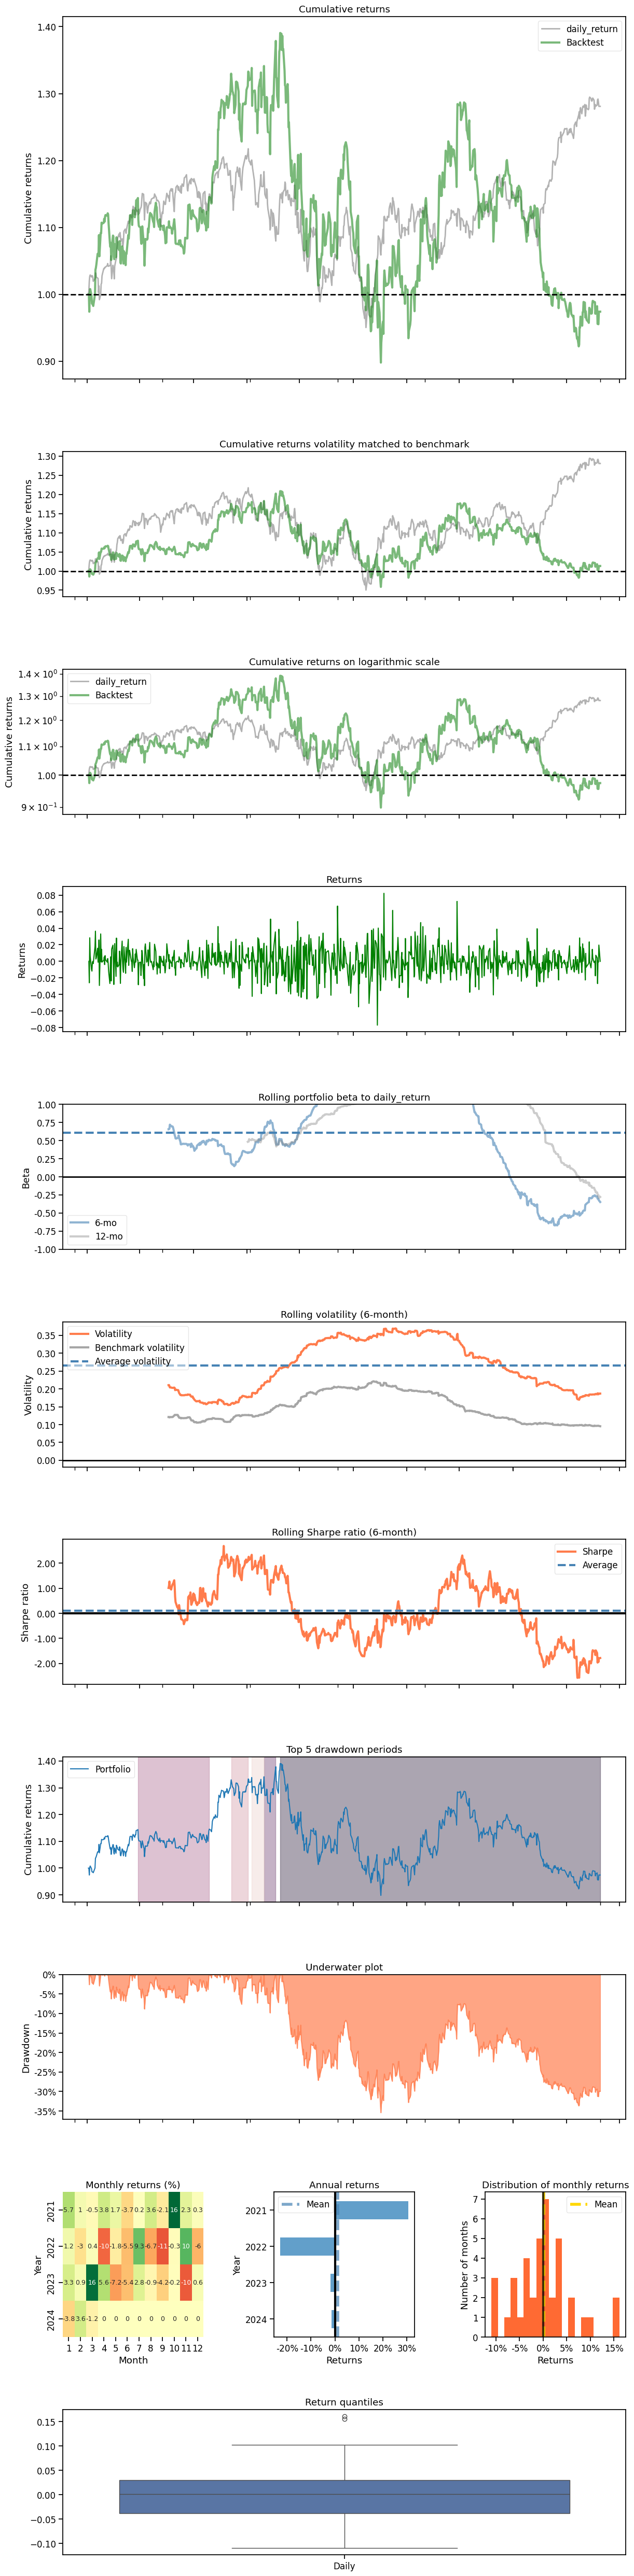

In [83]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(daily_account_value, 
            baseline_ticker = '^DJI', 
            baseline_start = TEST_START_DATE,
            baseline_end = TEST_END_DATE)

### Compare to Buy&Hold Strategy
pass in df_account_value, this information is stored in env class

<a id='6.2'></a>
## 7.2 BackTest with Buy&Hold Strategy

In [145]:
# print(DOW_30_TICKER)
# test_portfolio = DOW_30_TICKER
test_portfolio = ['MCD']
modify_fields = ['open','high','low','close']
used_columns = ['date','close']

In [146]:
#baseline stats
print("==============Get Baseline Stats===========")
shape = daily_account_value.shape
df_hold_ = pd.DataFrame(0,index=range(shape[0]), columns=range(shape[1]))
df_hold_.columns = used_columns
df_hold_['date'] = daily_account_value.date

for stock in test_portfolio:
    df_stock_ = get_baseline(
        ticker=stock, 
        start = TEST_START_DATE,
        end = TEST_END_DATE)
    # for field in modify_fields:
    if len(df_stock_) < len(df_hold_):
        final_row = df_stock_.iloc[-1]
        new_rows = pd.DataFrame([final_row] * (len(df_hold_) - len(df_stock_)))
        df_stock_ = pd.concat([df_stock_, new_rows], ignore_index=True)
        
        for i in range(0,len(df_stock_) < len(df_hold_)):
            df_stock_.iloc[en(df_stock_)] = df_stock_.iloc[len(df_stock_-1)]
    df_stock_['close'] = df_stock_['close']/df_stock_.iloc[0]['close']/len(test_portfolio)
    df_hold_['close'] = df_hold_.close + df_stock_.close

stats = backtest_stats(df_hold_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (805, 8)
Annual return          0.117878
Cumulative returns     0.428188
Annual volatility      0.165445
Sharpe ratio           0.757173
Calmar ratio           0.684330
Stability              0.837018
Max drawdown          -0.172253
Omega ratio            1.136454
Sortino ratio          1.105968
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.118509
Daily value at risk   -0.020347
dtype: float64


The model' calculation encompass the entire timeframe, including non-working days. To address this, we need to determine the most appropriate method to fill up the weekend plots, for example backfilling.

In [147]:
df_hold = pd.DataFrame()
df_hold['date'] = daily_account_value['date']
df_hold['hold'] = df_hold_['close'] / df_hold_['close'][0] * env_kwargs["initial_amount"]
# print("df_hold: ", df_hold)
# df_dji.to_csv("df_dji.csv")
df_hold = df_hold.set_index(df_hold.columns[0])
print("df_hold: ", df_hold)
# df_hold.to_csv("df_dji+.csv")

# df_account_value.to_csv('df_account_value.csv')

df_hold:                      hold
date                    
2021-01-04  1.000000e+06
2021-01-05  1.005994e+06
2021-01-06  1.003711e+06
2021-01-07  1.008372e+06
2021-01-08  1.026877e+06
...                  ...
2024-03-12  1.505804e+06
2024-03-13  1.447221e+06
2024-03-14  1.441440e+06
2024-03-15  1.428188e+06
2024-03-18  1.428188e+06

[806 rows x 1 columns]


==============Compare to Buy&Hold===========
result:                     stock          hold
date                                  
2021-01-04  1.000000e+06  1.000000e+06
2021-01-05  1.004989e+06  1.005994e+06
2021-01-06  1.002708e+06  1.003711e+06
2021-01-07  1.007365e+06  1.008372e+06
2021-01-08  1.025849e+06  1.026877e+06
...                  ...           ...
2024-03-11  1.531962e+06  1.508413e+06
2024-03-12  1.529312e+06  1.505804e+06
2024-03-13  1.469818e+06  1.447221e+06
2024-03-14  1.463947e+06  1.441440e+06
2024-03-15  1.450489e+06  1.428188e+06

[805 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

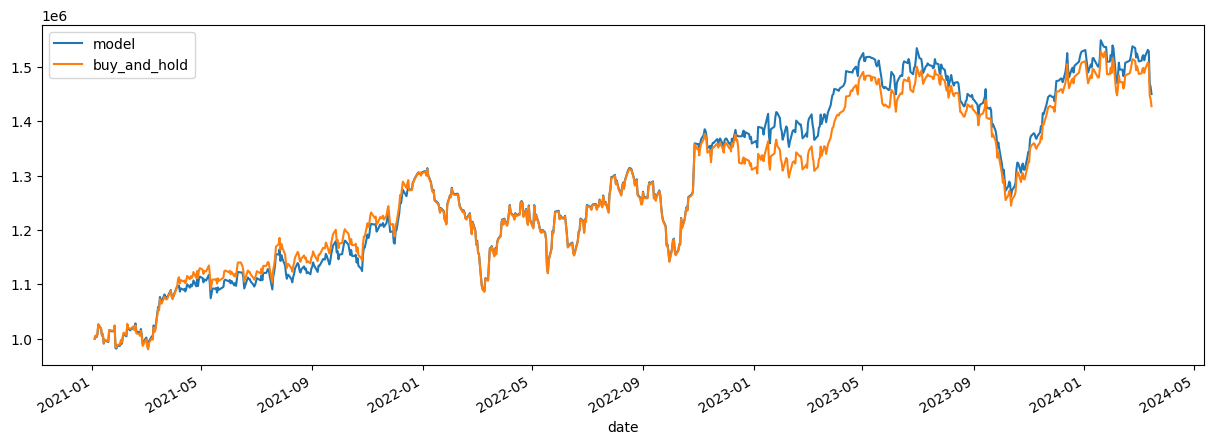

In [159]:
print("==============Compare to Buy&Hold===========")
df_result = pd.DataFrame({'date': df_account_value_ppo['date'], 'stock': df_account_value_ppo['account_value']})
df_result = df_result.set_index('date')

result = pd.DataFrame()
result = pd.merge(df_result, df_hold, left_index=True, right_index=True)
print("result: ", result)
# result.to_csv("result.csv")
result.columns = ['model', 'buy_and_hold']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

<a id='7'></a>
# 8. Save and load model #

<a id='7.1'></a>
## 8.1 Save model

### 8.1.1 Save trained model

In [62]:
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [65]:
model_name = "./"+TRAINED_MODEL_DIR+"/main_dow30_randomTic_discrete_standadized_shortSell_4hiden_ppo2_3_12m_steps"
model_name

'./trained_models/main_dow30_randomTic_discrete_standadized_shortSell_4hiden_ppo2_3_12m_steps'

In [66]:
trained_ppo.save(model_name)

### 8.1.2 Save model as ONNX file

In [74]:
import torch as th
import torch.onnx
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import DDPG
from stable_baselines3.common.policies import BasePolicy
from typing import Tuple

In [72]:
class OnnxableSB3Policy(th.nn.Module):
    def __init__(self, policy: BasePolicy):
        super().__init__()
        self.policy = policy

    def forward(self, observation: th.Tensor) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # NOTE: Preprocessing is included, but postprocessing
        # (clipping/inscaling actions) is not,
        # If needed, you also need to transpose the images so that they are channel first
        # use deterministic=False if you want to export the stochastic policy
        # policy() returns `actions, values, log_prob` for PPO
        return self.policy(observation, deterministic=True)

In [76]:
onnx_policy = OnnxableSB3Policy(trained_ppo.policy)
observation_size = trained_ppo.observation_space.shape
dummy_input = th.randn(1, *observation_size)

# th.onnx.export(
#     onnx_policy,
#     dummy_input,
#     "main_dow30_randomTic_discrete_shortSell_256neu_ppo_4m_steps.onnx",
#     opset_version=17,
#     input_names=["input"],
# )

In [77]:
onnx_policy

OnnxableSB3Policy(
  (policy): ActorCriticPolicy(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (pi_features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (vf_features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (mlp_extractor): MlpExtractor(
      (policy_net): Sequential(
        (0): Linear(in_features=19, out_features=256, bias=True)
        (1): Tanh()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): Tanh()
      )
      (value_net): Sequential(
        (0): Linear(in_features=19, out_features=256, bias=True)
        (1): Tanh()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): Tanh()
      )
    )
    (action_net): Linear(in_features=256, out_features=3, bias=True)
    (value_net): Linear(in_features=256, out_features=1, bias=True)
  )
)

<a id='7.2'></a>
## 8.2 Load model

<a id='7.2.1'></a>
### 8.2.1 Load trained model

In [58]:
from stable_baselines3 import PPO
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [59]:
model_name = "./"+TRAINED_MODEL_DIR+"/main_dow30_randomTic_discrete_standadized_shortSell_4hiden_ppo2_3_10m_steps"
model_name

'./trained_models/main_dow30_randomTic_discrete_standadized_shortSell_4hiden_ppo2_3_10m_steps'

In [60]:
trained_model = PPO.load(model_name)

Continous training based on the previous model at [**Part5. Train DRL Agents**](#5)

In [59]:
# #Establish the training environment using StockTradingEnv() class
# agent = DRLAgent(env = env_train)
# trained_model.env = env_train

In [64]:
# trained_ppo = agent.train_model(model=trained_model, 
#                              tb_log_name='ppo',
#                              total_timesteps=total_training_step)

#### Test loaded model

In [ ]:
test_env = StockTradingEnv(df = trade_data, **env_kwargs)

In [ ]:
test_step = 1000
test_result = []
test_env.reset()
for i in range(0,test_step):
    observation = [test_env.state]
    observation = np.array(observation).astype(np.float32)
    actions, values, log_prob = ort_sess.run(None, {"input": observation})
    result = test_env.step(actions)
    test_result.append(result[1])
    if result[2] == True:
        break

### 8.2.2 Load ONNX model

In [ ]:
import onnx
import onnxruntime as ort
import numpy as np

In [ ]:
onnx_path = "all_in_one_ppo.onnx"
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

# # Check that the predictions are the same
# with th.no_grad():
#     print(model.policy(th.as_tensor(observation), deterministic=True))

In [ ]:
observation = np.zeros((1, state_space)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
actions, values, log_prob = ort_sess.run(None, {"input": observation})
print(actions, values, log_prob)